# Cluster Analysis

The goal of this notebook is to get a deep understanding of how customers use the mobility service. Therefore we use clustering to better comprehend customers behavior.<br>
In this notebook we will do three clustering analysis: identify trip and customer types using specific features, taking into account weather data, considering spatial attributes, and clustering for spatial hot spots for trip demands.<br>
For each clustering task we will use a soft-clustering method and a hard-clustering method.

## 1 Imports

In [365]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import date, time, datetime, timedelta
#import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import mapclassify #import
import geopandas
#h3 import
#from ast import literal_eval as make_tuple
#import folium
#from folium import plugins
#from folium.plugins import HeatMap
import math
from math import sin, cos, pi
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [366]:
# edited trip dataframe 
df = pd.read_csv('data/prepared/taxi_weather.csv')
df

,trip_id,taxi_id,start_time,end_time,minutes,miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,temperature,wind_speed,precip,condition
0,bcfa19f2539021c054809d4c3993d226996ae095,368ce5511598af2cc07efdb68067d381174fdac1d47a28...,2022-01-01 00:00:00,2022-01-01 00:00:00,2.53,0.10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33,21.0,0.0,Light Snow / Windy
1,2aba69ff015f9ea8e7bff43cab7eddb228f34a12,449fa4909552757130d09d98ebc7770e2dd94579036b0e...,2022-01-01 00:00:00,2022-01-01 00:30:00,39.33,17.44,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),33,21.0,0.0,Light Snow / Windy
2,54d812a0b88f8f9707825261014b3563a0a60ace,f98ae5e71fdda8806710af321dce58002146886c013f41...,2022-01-01 00:00:00,2022-01-01 00:00:00,8.93,4.83,NaN,NaN,28.0,22.0,...,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205),33,21.0,0.0,Light Snow / Windy
3,040caea96573c5743668b138011bc157c7825e86,b9a58663518c48b09e83f462ca25ee0d702a2e4bc12199...,2022-01-01 00:00:00,2022-01-01 00:15:00,20.93,13.29,NaN,NaN,76.0,NaN,...,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN,33,21.0,0.0,Light Snow / Windy
4,0f0c856e620e6b4dfd2bb1e921d966dd179eeca1,b21050ab3ad3d0972fd6378f6bf4d0251a8a7af42e6e0e...,2022-01-01 00:00:00,2022-01-01 00:00:00,0.55,0.17,NaN,NaN,3.0,3.0,...,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),33,21.0,0.0,Light Snow / Windy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389585,ae3d90108a96c6492a6255f7fc6b85c8e7e0d12c,2eda36427e0a5394e90d77488294cd75e2fd87f04acb02...,2022-12-31 23:45:00,2022-12-31 23:45:00,3.27,0.57,NaN,NaN,6.0,6.0,...,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),37,6.0,0.0,Cloudy
5389586,ad84bc072bb580f059a1c2b71a808b21e28a28fb,ef63da921ed08ceb44e590dbb76b0505f1300167c24876...,2022-12-31 23:45:00,2022-12-31 23:45:00,5.90,0.85,1.703184e+10,1.703132e+10,32.0,32.0,...,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),37,6.0,0.0,Cloudy
5389587,b13dcd7ede0551d30944feab189891fdca8873b6,6201cd8256e26b0ef547ca53db3aaac4d23fc7d02e4c9f...,2022-12-31 23:45:00,2022-12-31 23:45:00,1.72,0.31,NaN,NaN,3.0,3.0,...,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),37,6.0,0.0,Cloudy
5389588,d35a54c3d20c5275718151191d6cbd3624640931,e87c704a9b1b4c7e9036508cc65d110d38bb2f8d12414b...,2022-12-31 23:45:00,2022-12-31 23:45:00,8.33,1.58,NaN,NaN,7.0,7.0,...,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),37,6.0,0.0,Cloudy


## 2 Data Preparation

As the data was already prepared in the Data_Preparation only some minor preparation need to be done, furthermore we calculate some additional features.


We used the trip start time over the end time to define the times like hour and day of week because the start of a trip is more relevant for the calculations. With most of the trips being very short, it does not make a huge difference though.

In [367]:
# drop the column that are not used in the analysis
df.drop(['trip_id', 'taxi_id', 'end_time', 'pickup_census_tract', 'dropoff_census_tract', 
            'tolls', 'extras', 'total', 'payment_type', 'pickup_centroid_location', 'condition',
            'dropoff_centroid_location', 'pickup_community_area', 'dropoff_community_area'], axis=1, inplace=True)

df

,start_time,minutes,miles,fare,tips,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,temperature,wind_speed,precip
0,2022-01-01 00:00:00,2.53,0.10,3.75,0.0,Medallion Leasin,NaN,NaN,NaN,NaN,33,21.0,0.0
1,2022-01-01 00:00:00,39.33,17.44,47.75,0.0,Flash Cab,NaN,NaN,41.899602,-87.633308,33,21.0,0.0
2,2022-01-01 00:00:00,8.93,4.83,14.75,0.0,Globe Taxi,41.874005,-87.663518,41.922761,-87.699155,33,21.0,0.0
3,2022-01-01 00:00:00,20.93,13.29,34.00,0.0,City Service,41.980264,-87.913625,NaN,NaN,33,21.0,0.0
4,2022-01-01 00:00:00,0.55,0.17,63.27,0.0,Flash Cab,41.965812,-87.655879,41.965812,-87.655879,33,21.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389585,2022-12-31 23:45:00,3.27,0.57,4.75,2.0,Taxicab Insurance Agency Llc,41.944227,-87.655998,41.944227,-87.655998,37,6.0,0.0
5389586,2022-12-31 23:45:00,5.90,0.85,5.75,0.0,City Service,41.880994,-87.632746,41.884987,-87.620993,37,6.0,0.0
5389587,2022-12-31 23:45:00,1.72,0.31,4.00,0.0,Taxicab Insurance Agency Llc,41.965812,-87.655879,41.965812,-87.655879,37,6.0,0.0
5389588,2022-12-31 23:45:00,8.33,1.58,11.00,10.0,City Service,41.922686,-87.649489,41.922686,-87.649489,37,6.0,0.0


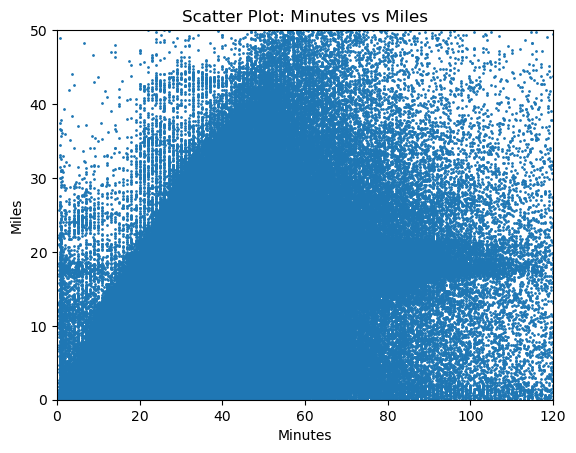

In [368]:
#show the distribution of miles vs minutes
mpl.rcParams['agg.path.chunksize'] = 10000

# Create a figure and axis
fig, ax = plt.subplots()

# Plotting the data
plt.scatter(df['minutes'], df['miles'], s=1)  # 's' controls the size of the points

ax.set_xlim(0, 120)
ax.set_ylim(0, 50)

# Adding labels and title
plt.xlabel('Minutes')
plt.ylabel('Miles')
plt.title('Scatter Plot: Minutes vs Miles')

# Displaying the plot
plt.show()

Using less features is often advisable to avoid overfitting and wrong analysis focus. That´s why we asked ourselves if both the features miles and time (here minutes) is necessary. We plotted distribution of miles vs minutes of the trips and it is visible that the distribution is rather linear. Therefore we decided to use mainly one feature for the further analysis and our decision fell on miles. We expect of miles better understanding of customer behaviour, why they decided to use a taxi for a short trip for example. The time feature is also often influenced by other factors like traffic in a big city like Chicago.

In [369]:
# format the start time and add columns weekend, month and time
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M')

df['weekend'] = df.start_time.apply(lambda x: 0 if x.day_of_week <= 4 else 1)

df['month'] = df.start_time.apply(lambda x: x.month)

df["time"]= df.start_time.apply(lambda x: (x.hour)+(x.minute/60))

df

,start_time,minutes,miles,fare,tips,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,temperature,wind_speed,precip,weekend,month,time
0,2022-01-01 00:00:00,2.53,0.10,3.75,0.0,Medallion Leasin,NaN,NaN,NaN,NaN,33,21.0,0.0,1,1,0.00
1,2022-01-01 00:00:00,39.33,17.44,47.75,0.0,Flash Cab,NaN,NaN,41.899602,-87.633308,33,21.0,0.0,1,1,0.00
2,2022-01-01 00:00:00,8.93,4.83,14.75,0.0,Globe Taxi,41.874005,-87.663518,41.922761,-87.699155,33,21.0,0.0,1,1,0.00
3,2022-01-01 00:00:00,20.93,13.29,34.00,0.0,City Service,41.980264,-87.913625,NaN,NaN,33,21.0,0.0,1,1,0.00
4,2022-01-01 00:00:00,0.55,0.17,63.27,0.0,Flash Cab,41.965812,-87.655879,41.965812,-87.655879,33,21.0,0.0,1,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389585,2022-12-31 23:45:00,3.27,0.57,4.75,2.0,Taxicab Insurance Agency Llc,41.944227,-87.655998,41.944227,-87.655998,37,6.0,0.0,1,12,23.75
5389586,2022-12-31 23:45:00,5.90,0.85,5.75,0.0,City Service,41.880994,-87.632746,41.884987,-87.620993,37,6.0,0.0,1,12,23.75
5389587,2022-12-31 23:45:00,1.72,0.31,4.00,0.0,Taxicab Insurance Agency Llc,41.965812,-87.655879,41.965812,-87.655879,37,6.0,0.0,1,12,23.75
5389588,2022-12-31 23:45:00,8.33,1.58,11.00,10.0,City Service,41.922686,-87.649489,41.922686,-87.649489,37,6.0,0.0,1,12,23.75


Because time has a circular characteristic and we do not want hour 23 being very far from hour 0, we have to adjust the variables. <br> Therefore, we transform the hour into a circular representation by using sin and cos functions.

In [370]:
# function to create sin and cos feature of variables
def sin_cos_feature(name, df, feature, values):
    df[name+"_sin"]= feature.apply(lambda x: sin(2*pi*(int(x)/values)))
    df[name+"_cos"]= feature.apply(lambda x: cos(2*pi*(int(x)/values)))

# new circular feature for hour
sin_cos_feature("time", df, df.time, 24)

# drop unnecessary features for the cluster analysis
df = df.drop(["start_time"], axis=1)
df

,minutes,miles,fare,tips,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,temperature,wind_speed,precip,weekend,month,time,time_sin,time_cos
0,2.53,0.10,3.75,0.0,Medallion Leasin,NaN,NaN,NaN,NaN,33,21.0,0.0,1,1,0.00,0.000000,1.000000
1,39.33,17.44,47.75,0.0,Flash Cab,NaN,NaN,41.899602,-87.633308,33,21.0,0.0,1,1,0.00,0.000000,1.000000
2,8.93,4.83,14.75,0.0,Globe Taxi,41.874005,-87.663518,41.922761,-87.699155,33,21.0,0.0,1,1,0.00,0.000000,1.000000
3,20.93,13.29,34.00,0.0,City Service,41.980264,-87.913625,NaN,NaN,33,21.0,0.0,1,1,0.00,0.000000,1.000000
4,0.55,0.17,63.27,0.0,Flash Cab,41.965812,-87.655879,41.965812,-87.655879,33,21.0,0.0,1,1,0.00,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389585,3.27,0.57,4.75,2.0,Taxicab Insurance Agency Llc,41.944227,-87.655998,41.944227,-87.655998,37,6.0,0.0,1,12,23.75,-0.258819,0.965926
5389586,5.90,0.85,5.75,0.0,City Service,41.880994,-87.632746,41.884987,-87.620993,37,6.0,0.0,1,12,23.75,-0.258819,0.965926
5389587,1.72,0.31,4.00,0.0,Taxicab Insurance Agency Llc,41.965812,-87.655879,41.965812,-87.655879,37,6.0,0.0,1,12,23.75,-0.258819,0.965926
5389588,8.33,1.58,11.00,10.0,City Service,41.922686,-87.649489,41.922686,-87.649489,37,6.0,0.0,1,12,23.75,-0.258819,0.965926


In [371]:
#calculate distance to city center for pickup and dropoff
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Radius of the Earth in kilometers
    radius = 6371
    # Calculate the distance
    distance = radius * c
    
    # if the first coordinate is south of the second one, negate the distance
    if lat1 < lat2:
        distance *=-1

    return distance

#drop NaN values of coordinates to be able to work with all other rows
df = df.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude'])

center_lat = 41.879519
center_lon = -87.633026

df.loc[:,'pickup_center_distance'] = df.apply(lambda x: calculate_distance(x['pickup_centroid_latitude'], x['pickup_centroid_longitude'], center_lat, center_lon), axis=1)
df.loc[:,'dropoff_center_distance'] = df.apply(lambda x: calculate_distance(x['dropoff_centroid_latitude'], x['dropoff_centroid_longitude'], center_lat, center_lon), axis=1)

df

,minutes,miles,fare,tips,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,temperature,wind_speed,precip,weekend,month,time,time_sin,time_cos,pickup_center_distance,dropoff_center_distance
2,8.93,4.83,14.75,0.0,Globe Taxi,41.874005,-87.663518,41.922761,-87.699155,33,21.0,0.0,1,1,0.00,0.000000,1.000000,-2.597889,7.285127
4,0.55,0.17,63.27,0.0,Flash Cab,41.965812,-87.655879,41.965812,-87.655879,33,21.0,0.0,1,1,0.00,0.000000,1.000000,9.779843,9.779843
5,11.83,3.12,11.00,0.0,Sun Taxi,41.922686,-87.649489,41.965812,-87.655879,33,21.0,0.0,1,1,0.00,0.000000,1.000000,4.989611,9.779843
7,5.00,1.40,6.75,0.0,Taxi Affiliation Services,41.857184,-87.620335,41.857184,-87.620335,33,21.0,0.0,1,1,0.00,0.000000,1.000000,-2.696747,-2.696747
9,15.58,4.66,15.25,0.0,Sun Taxi,41.899602,-87.633308,41.944227,-87.655998,33,21.0,0.0,1,1,0.00,0.000000,1.000000,2.233262,7.442025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389585,3.27,0.57,4.75,2.0,Taxicab Insurance Agency Llc,41.944227,-87.655998,41.944227,-87.655998,37,6.0,0.0,1,12,23.75,-0.258819,0.965926,7.442025,7.442025
5389586,5.90,0.85,5.75,0.0,City Service,41.880994,-87.632746,41.884987,-87.620993,37,6.0,0.0,1,12,23.75,-0.258819,0.965926,0.165689,1.167082
5389587,1.72,0.31,4.00,0.0,Taxicab Insurance Agency Llc,41.965812,-87.655879,41.965812,-87.655879,37,6.0,0.0,1,12,23.75,-0.258819,0.965926,9.779843,9.779843
5389588,8.33,1.58,11.00,10.0,City Service,41.922686,-87.649489,41.922686,-87.649489,37,6.0,0.0,1,12,23.75,-0.258819,0.965926,4.989611,4.989611


For our first three cluster analysis we us the following features:
* time (as hour + 15min steps format) with the use of sin/cos, weekend, miles
* miles, temperature, precipitation
* distance from pickup to city center, distance from dropoff to city center

In [372]:
df_1 = df[['time_sin', 'time_cos', 'weekend', 'miles']]

df_2 = df[['miles', 'temperature', 'precip']]

df_3 = df[['pickup_center_distance', 'dropoff_center_distance']]

df_1

,time_sin,time_cos,weekend,miles
2,0.000000,1.000000,1,4.83
4,0.000000,1.000000,1,0.17
5,0.000000,1.000000,1,3.12
7,0.000000,1.000000,1,1.40
9,0.000000,1.000000,1,4.66
...,...,...,...,...
5389585,-0.258819,0.965926,1,0.57
5389586,-0.258819,0.965926,1,0.85
5389587,-0.258819,0.965926,1,0.31
5389588,-0.258819,0.965926,1,1.58


To achieve the same weights for all of the features, we standardize the dataframes.

In [373]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_1)
X_scaled_1 = scaler.transform(df_1)
df_scaled_1 = pd.DataFrame(X_scaled_1, columns=df_1.columns, index=df_1.index)
df_scaled_1.head()

,time_sin,time_cos,weekend,miles
2,0.389444,2.046813,1.801441,-0.218639
4,0.389444,2.046813,1.801441,-0.945221
5,0.389444,2.046813,1.801441,-0.485261
7,0.389444,2.046813,1.801441,-0.753441
9,0.389444,2.046813,1.801441,-0.245146


In [374]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_2)
X_scaled_2 = scaler.transform(df_2)
df_scaled_2 = pd.DataFrame(X_scaled_2, columns=df_2.columns, index=df_2.index)
df_scaled_2.head()

,miles,temperature,precip
2,-0.218639,-1.141637,-0.115196
4,-0.945221,-1.141637,-0.115196
5,-0.485261,-1.141637,-0.115196
7,-0.753441,-1.141637,-0.115196
9,-0.245146,-1.141637,-0.115196


In [375]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_3)
X_scaled_3 = scaler.transform(df_3)
df_scaled_3 = pd.DataFrame(X_scaled_3, columns=df_3.columns, index=df_3.index)
df_scaled_3.head()

,pickup_center_distance,dropoff_center_distance
2,-0.612912,0.546145
4,0.530319,0.831631
5,0.087884,0.831631
7,-0.622042,-0.596143
9,-0.166697,0.564099


## 3 Clustering

For each clustering task two methods are usec. For soft-clustering we decided for Gaussian Mixture Model (GMM) as for hard-clustering we decided for K-Means.<br>
GMM is great when data points might belong to multiple clusters to varying extents. GMM's probabilistic approach allows for flexible cluster assignments, capturing uncertainty. K-Means is ideal for hard clustering when data points are clearly separable into distinct clusters, providing definitive assignments without considering uncertainties. The choice between GMM and K-Means depends on data characteristics and analysis goals, allowing selection of the appropriate clustering approach.<br>
With the use of both approaches side-to-side we expect to clearly observe the different advantages.

### 3.1 Trip Clustering

As a first step, we determine the number of clusters we want to use. We use the elbow-method, therefore we plot the loss for the different number of clusters.

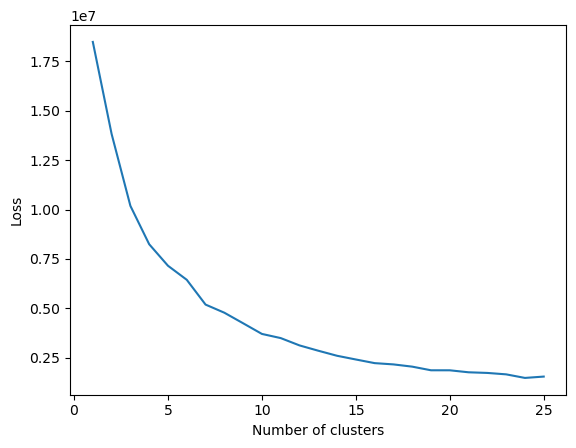

In [377]:
k_max = 25
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_1)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

Using the elbow method good results promises a cluster number of 6.

We use K-Means++ for initialization at K-Means, because it improves the selection of initial cluster centroids by spreading them out in a way that promotes convergence and reduces the likelihood of getting stuck in suboptimal solutions.


In [381]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7, random_state=42)
gmm.fit(X_scaled_1)
df_1['cluster_gmm'] = gmm.predict(X_scaled_1) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=7, random_state=42, init="k-means++")
means.fit(X_scaled_1)
df_1['cluster_km'] = means.predict(X_scaled_1)

# add features for analysis
df_1['time'] = df.time

# cluster int to string
cluster = ["1", "2", "3", "4", "5", "6", "7"]
df_1["cluster_gmm"] = df_1["cluster_gmm"].apply(lambda x: cluster[x])
df_1["cluster_km"] = df_1["cluster_km"].apply(lambda x: cluster[x])

df_1

,time_sin,time_cos,weekend,miles,cluster_km,time,cluster_gmm
2,0.000000,1.000000,1,4.83,3,0.00,2
4,0.000000,1.000000,1,0.17,3,0.00,2
5,0.000000,1.000000,1,3.12,3,0.00,2
7,0.000000,1.000000,1,1.40,3,0.00,2
9,0.000000,1.000000,1,4.66,3,0.00,2
...,...,...,...,...,...,...,...
5389585,-0.258819,0.965926,1,0.57,3,23.75,2
5389586,-0.258819,0.965926,1,0.85,3,23.75,2
5389587,-0.258819,0.965926,1,0.31,3,23.75,2
5389588,-0.258819,0.965926,1,1.58,3,23.75,2


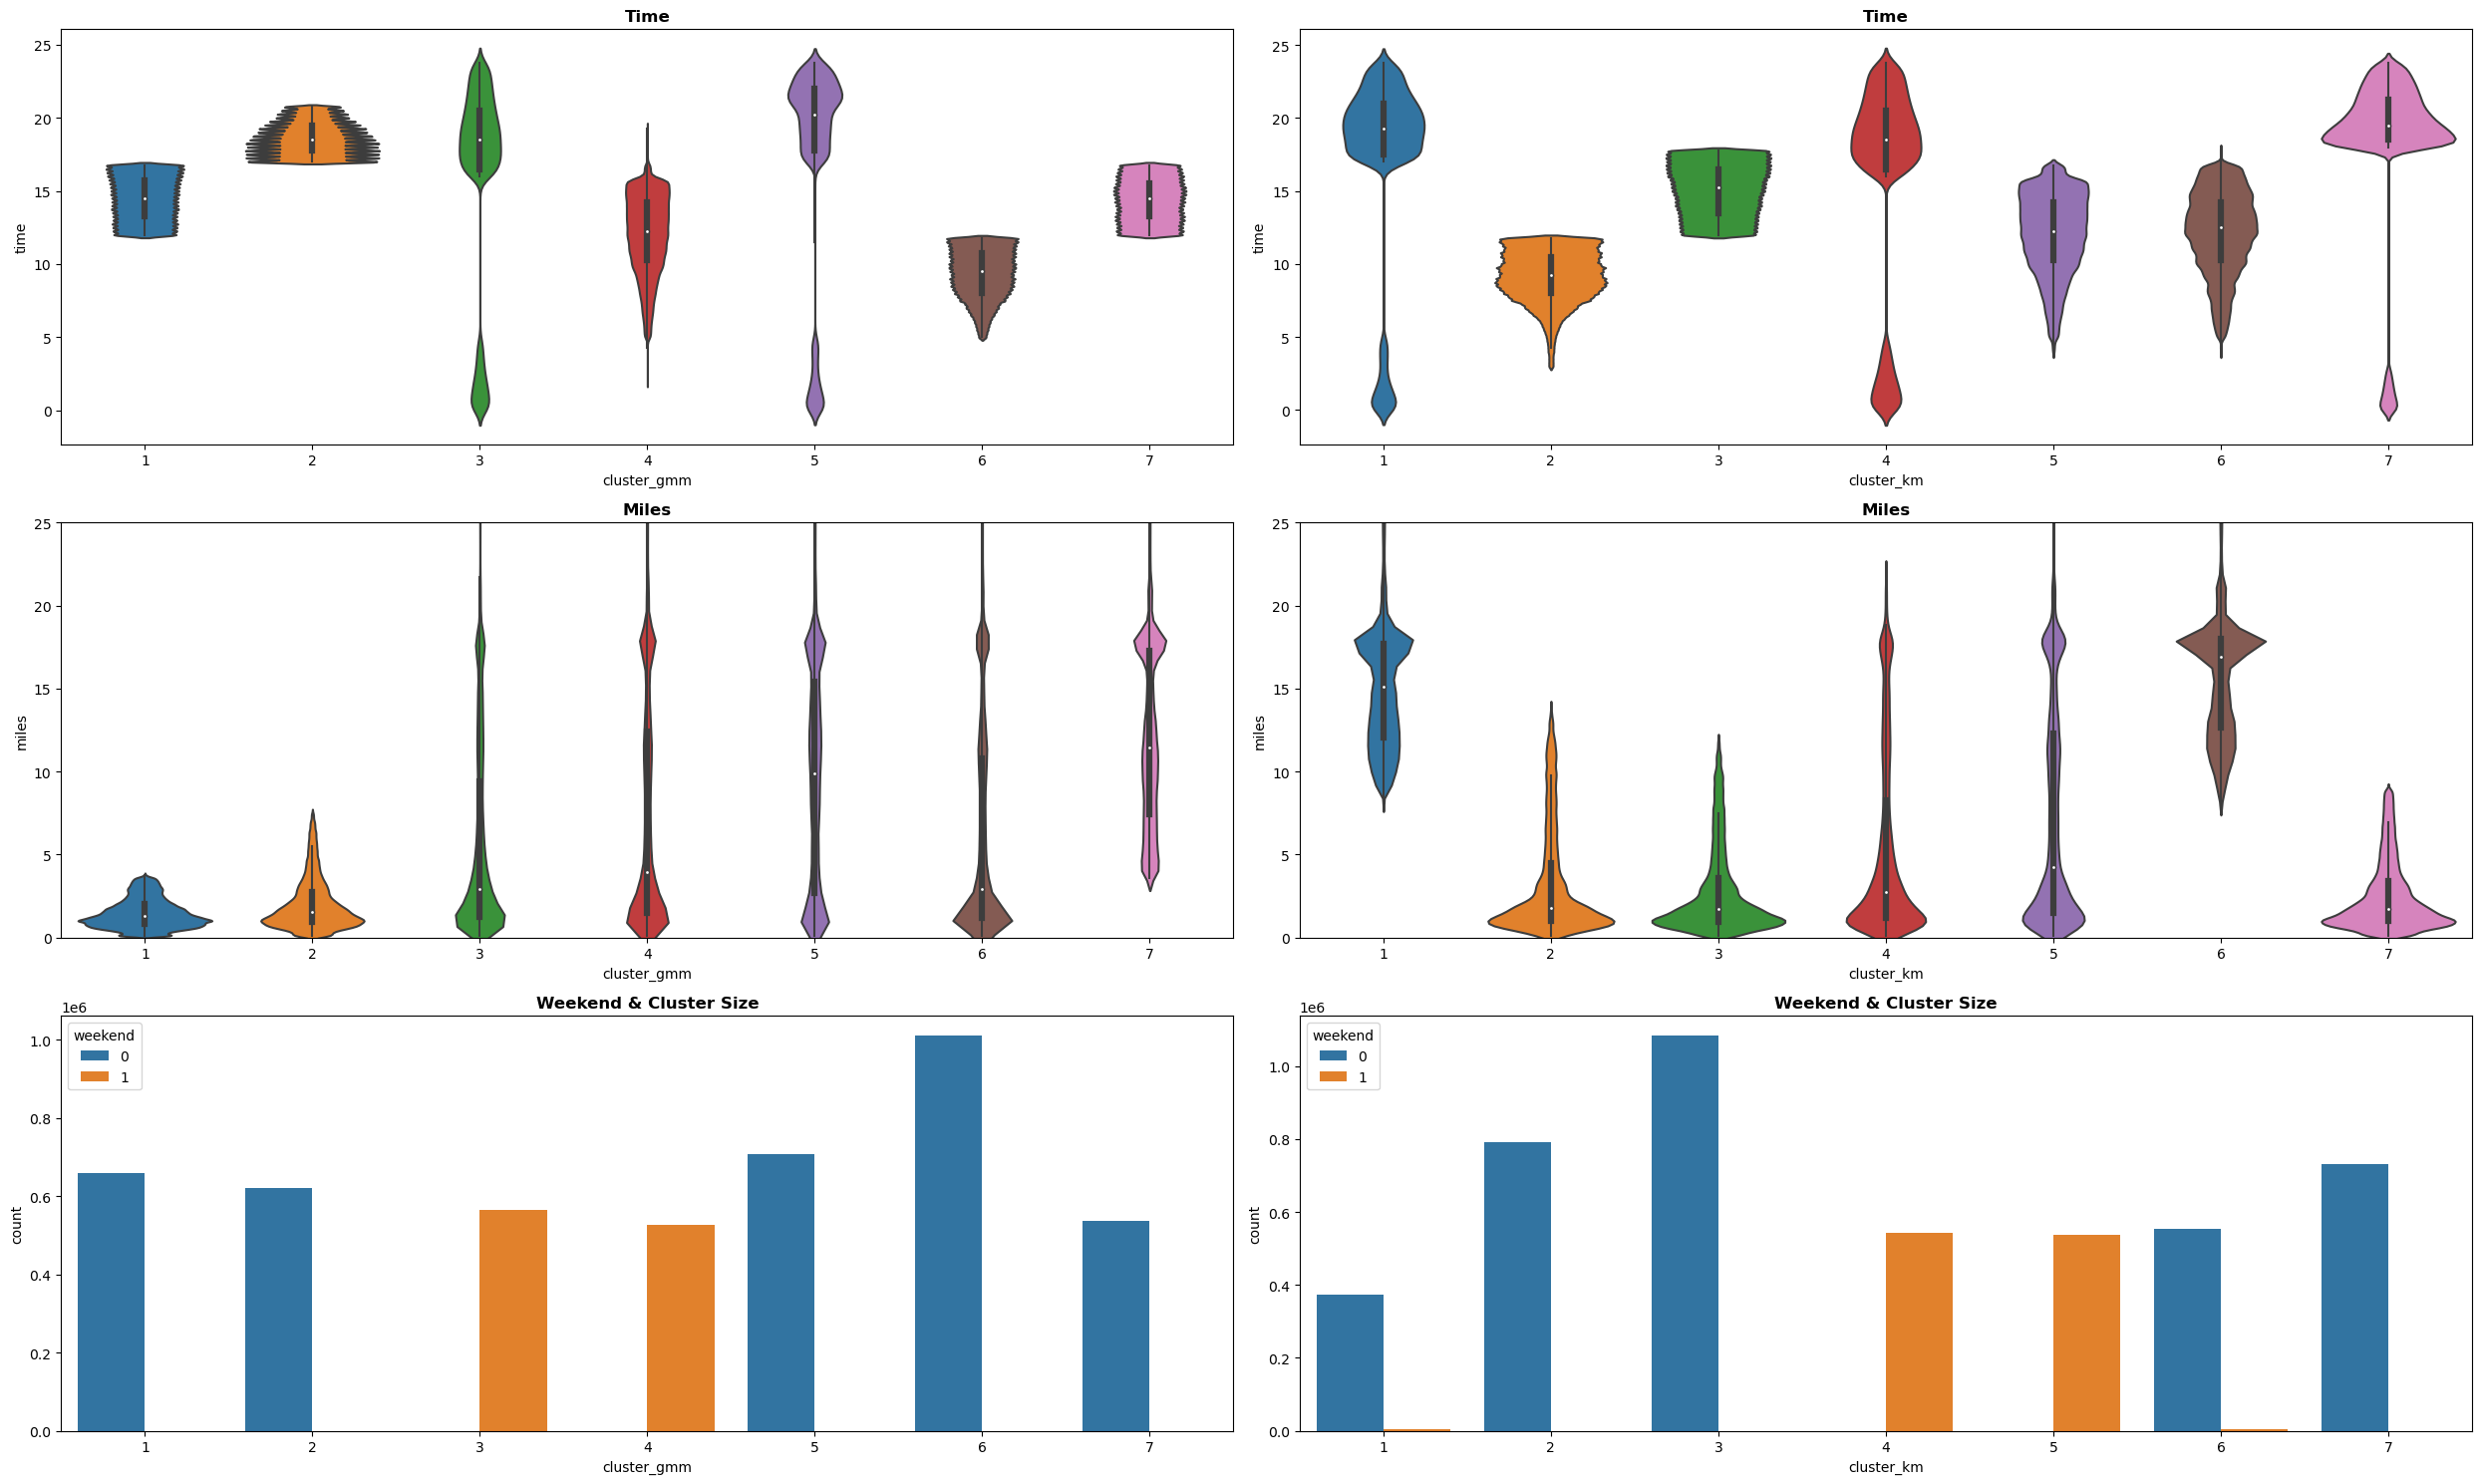

In [578]:
# visualize cluters regarding Time, Miles, weekend and cluster size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 15))

order = ['1', '2', '3', '4', '5', '6', '7']

# Violin plots and count plots for GMM
sns.violinplot(ax=axes[0, 0], x=df_1['cluster_gmm'], y=df_1['time'], data=df_1, order=order)
axes[0, 0].set_title('Time', fontweight='bold')

sns.violinplot(ax=axes[1, 0], x=df_1['cluster_gmm'], y=df_1['miles'], data=df_1, order=order)
axes[1, 0].set_title('Miles', fontweight='bold')
axes[1, 0].set_ylim(0, 25)

sns.countplot(ax=axes[2, 0], x=df_1['cluster_gmm'], hue=df_1['weekend'], data=df_1, order=order)
axes[2, 0].set_title('Weekend & Cluster Size', fontweight='bold')

# Violin plots and count plots for K-means
sns.violinplot(ax=axes[0, 1], x=df_1['cluster_km'], y=df_1['time'], data=df_1, order=order)
axes[0, 1].set_title('Time', fontweight='bold')

sns.violinplot(ax=axes[1, 1], x=df_1['cluster_km'], y=df_1['miles'], data=df_1, order=order)
axes[1, 1].set_title('Miles', fontweight='bold')
axes[1, 1].set_ylim(0, 25)

sns.countplot(ax=axes[2, 1], x=df_1['cluster_km'], hue=df_1['weekend'], data=df_1, order=order)
axes[2, 1].set_title('Weekend & Cluster Size', fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 3.2 Trip-Weather Clustering

As a first step, we determine the number of clusters we want to use. We use the elbow-method, therefore we plot the loss for the different number of clusters.

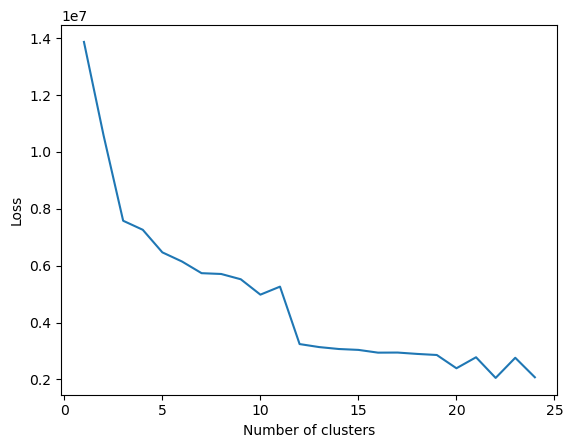

In [ ]:
k_max = 24
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_2)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

Using the elbow method good results promises a cluster number of 12. Other cluster numbers of e.g. 3 and 10 were also tested but 12 presents the best results.

In [872]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=12, random_state=42)
gmm.fit(X_scaled_2)
df_2['cluster_gmm'] = gmm.predict(X_scaled_2) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=12, random_state=42, init="k-means++")
means.fit(X_scaled_2)
df_2['cluster_km'] = means.predict(X_scaled_2)

# cluster int to string
cluster = ["1", "2", "3", "4", "5", "6", "7", "8", "9","10","11","12"]
df_2["cluster_gmm"] = df_2["cluster_gmm"].apply(lambda x: cluster[x])
df_2["cluster_km"] = df_2["cluster_km"].apply(lambda x: cluster[x])

df_2

,miles,temperature,precip,cluster_gmm,cluster_km
2,4.83,33,0.0,2,1
4,0.17,33,0.0,3,8
5,3.12,33,0.0,3,8
7,1.40,33,0.0,3,8
9,4.66,33,0.0,2,1
...,...,...,...,...,...
5389585,0.57,37,0.0,3,8
5389586,0.85,37,0.0,3,8
5389587,0.31,37,0.0,3,8
5389588,1.58,37,0.0,3,8


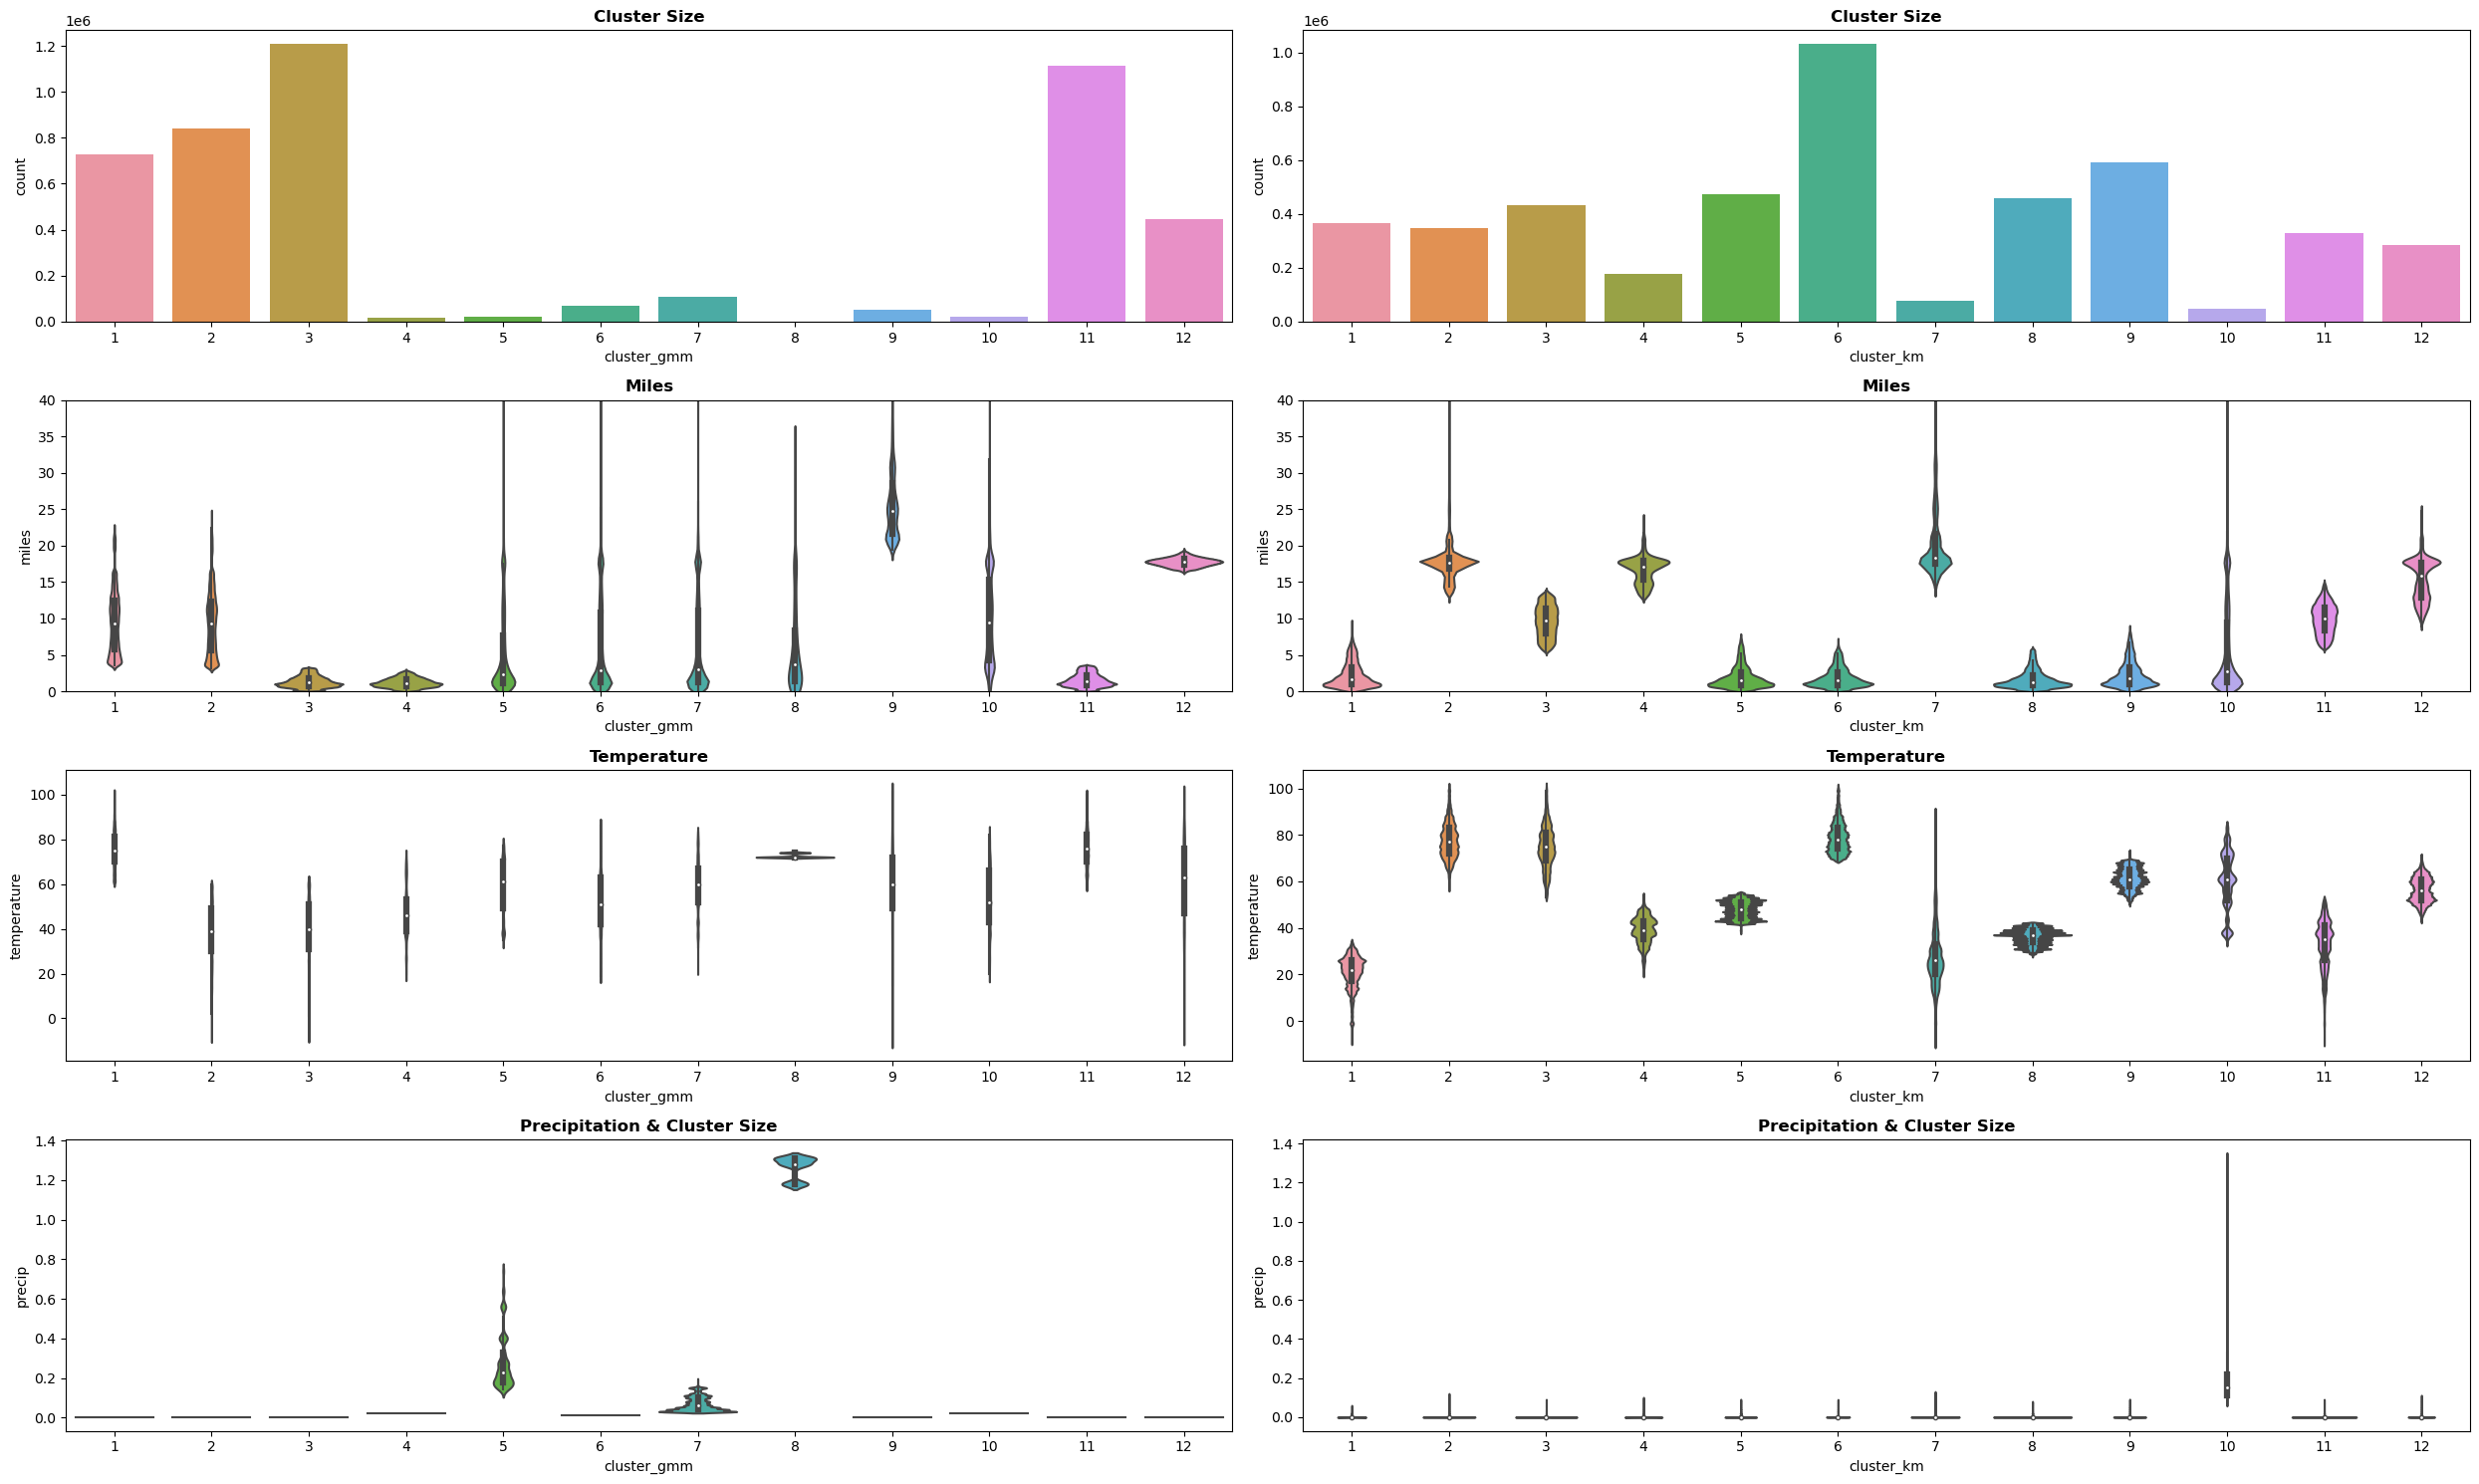

In [ ]:
# visualize cluters regarding cluster size, miles, temperature, precipitation
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 15))

order = ["1", "2", "3", "4", "5", "6", "7", "8", "9","10","11","12"]

sns.countplot(ax=axes[0, 0], x=df_2['cluster_gmm'], data=df_2, order=order)
axes[0, 0].set_title('GMM Cluster Size', fontweight='bold')

sns.violinplot(ax=axes[1, 0], x=df_2['cluster_gmm'], y=df_2['miles'], data=df_2, order=order)
axes[1, 0].set_title('Miles', fontweight='bold')
axes[1, 0].set_ylim(0, 35)

sns.violinplot(ax=axes[2, 0], x=df_2['cluster_gmm'], y=df_2['temperature'], data=df_2, order=order)
axes[2, 0].set_title('Temperature', fontweight='bold')

sns.violinplot(ax=axes[3, 0], x=df_2['cluster_gmm'], y=df_2['precip'], data=df_2, order=order)
axes[3, 0].set_title('Precipitation', fontweight='bold')

sns.countplot(ax=axes[0, 1], x=df_2['cluster_km'], data=df_2, order=order)
axes[0, 1].set_title('K-Means Cluster Size', fontweight='bold')

sns.violinplot(ax=axes[1, 1], x=df_2['cluster_km'], y=df_2['miles'], data=df_2, order=order)
axes[1, 1].set_title('Miles', fontweight='bold')
axes[1, 1].set_ylim(0, 35)

sns.violinplot(ax=axes[2, 1], x=df_2['cluster_km'], y=df_2['temperature'], data=df_2, order=order)
axes[2, 1].set_title('Temperature', fontweight='bold')

sns.violinplot(ax=axes[3, 1], x=df_2['cluster_km'], y=df_2['precip'], data=df_2, order=order)
axes[3, 1].set_title('Precipitation', fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

For better understanding we visualized the different clusters regarding: hour, day of week (with Monday starting on 0), duration per trip, user type, trip distribution. For detailed view, we also zoomed in for the duration per trip.<br>
Now we can use these plots to describe and analyze the clusters and identify trip and customer types.

**Cluster 1**: short trips which are mainly in the early hours on weekdays of subscribers. The peak lies on about 8 hours. People cycle to work in the morning.<br>
**Cluster 2**: little bit longer trips during the whole day of customers, with slightly more distribution on the weekend. Spontaneous/unregular bike trips between about 20 minutes and 1 hour.<br>
**Cluster 3**: short trips in the afternoon on weekdays of subscribers. The peak lies on about 17 hours. People cycle home after work. The distribution of this cluster is as high as cluster 1, which also indicates that people cycle both to work and home.<br>
**Cluster 4**: short trips in the night over the whole week of subscribers. The highest distribution lies around Friday, so this cluster contains the trips of people after going out.<br>
**Cluster 5**: short trips at daytime mostly at the end of the week of subscribers. These are the trips in the free time of people.<br>
**Cluster 6**: very long trips during the whole day mostly of customers, with slightly more distribution on the weekend. Very low distribution overall. Spontaneous/unregular bike trips over 1 hour, the .<br>

All the clusters make sense and fulfill the expectations, so we see the number 6 for the clusters with the used features as fitting. The gained insights of this analysis can be used to adapt and improve the bike-rental-services.

### 3.3 Trip-Distance Clustering

As a first step, we determine the number of clusters we want to use. We use the elbow-method, therefore we plot the loss for the different number of clusters.

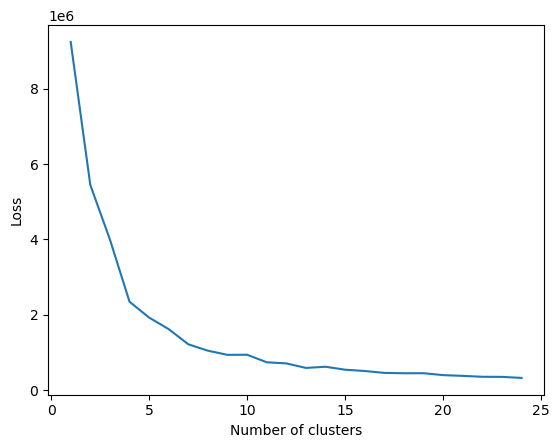

In [871]:
k_max = 24
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_3)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

Using the elbow method good results promises a cluster number of 7.

In [ ]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7, random_state=42)
gmm.fit(X_scaled_3)
df_3['cluster_gmm'] = gmm.predict(X_scaled_3) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=7, random_state=42, init="k-means++")
means.fit(X_scaled_3)
df_3['cluster_km'] = means.predict(X_scaled_3)

# cluster int to string
cluster = ["1", "2", "3", "4", "5", "6", "7"]
df_3["cluster_gmm"] = df_3["cluster_gmm"].apply(lambda x: cluster[x])
df_3["cluster_km"] = df_3["cluster_km"].apply(lambda x: cluster[x])

df_3

,pickup_center_distance,dropoff_center_distance,cluster_gmm,cluster_km
2,-2.597889,7.285127,0,4
4,9.779843,9.779843,0,4
5,4.989611,9.779843,0,4
7,-2.696747,-2.696747,3,0
9,2.233262,7.442025,0,4
...,...,...,...,...
5389585,7.442025,7.442025,0,4
5389586,0.165689,1.167082,3,0
5389587,9.779843,9.779843,0,4
5389588,4.989611,4.989611,0,4


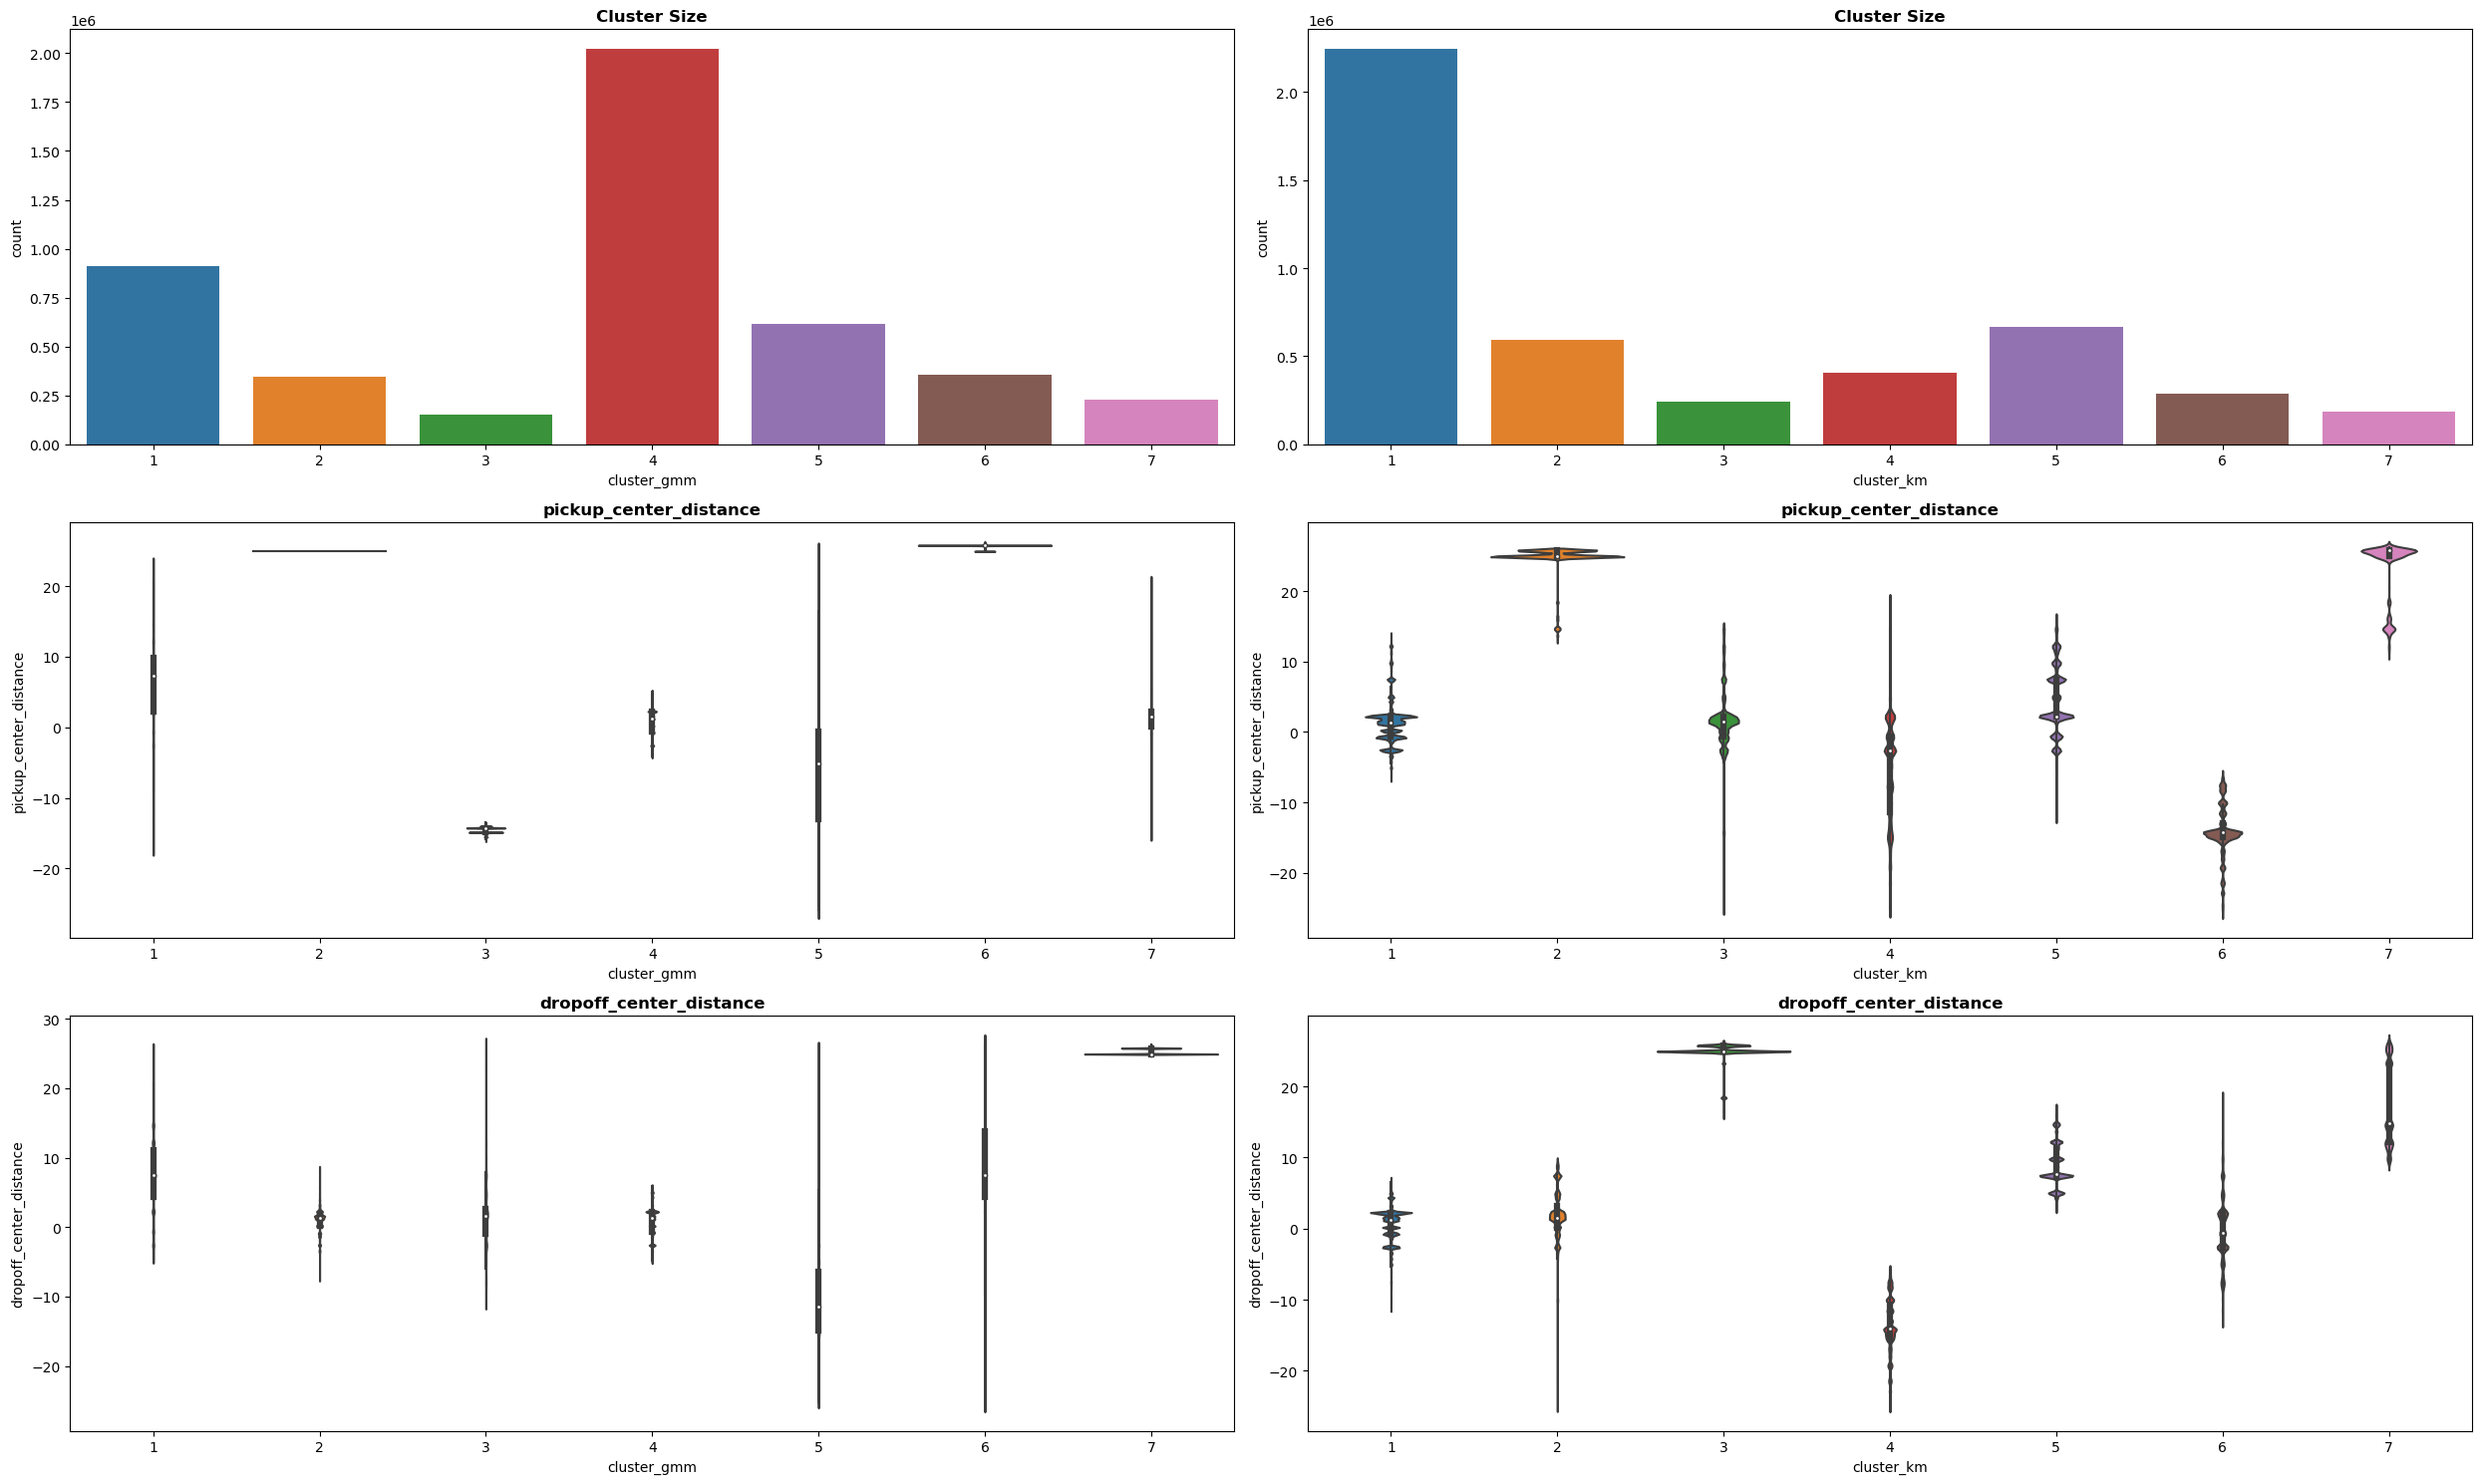

In [ ]:
# visualize cluters regarding cluster size, distance from pickup to city center, distance from dropoff to city center
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 15))

order = ['1', '2', '3', '4', '5', '6', '7']

# Violin plots and count plots for GMM
sns.countplot(ax=axes[0, 0], x=df_3['cluster_gmm'], data=df_3, order=order)
axes[0, 0].set_title('Cluster Size', fontweight='bold')

sns.violinplot(ax=axes[1, 0], x=df_3['cluster_gmm'], y=df_3['pickup_center_distance'], data=df_3, order=order)
axes[1, 0].set_title('pickup_center_distance', fontweight='bold')

sns.violinplot(ax=axes[2, 0], x=df_3['cluster_gmm'], y=df_3['dropoff_center_distance'], data=df_3, order=order)
axes[2, 0].set_title('dropoff_center_distance', fontweight='bold')


# Violin plots and count plots for K-means
sns.countplot(ax=axes[0, 1], x=df_3['cluster_km'], data=df_3, order=order)
axes[0, 1].set_title('Cluster Size', fontweight='bold')

sns.violinplot(ax=axes[1, 1], x=df_3['cluster_km'], y=df_3['pickup_center_distance'], data=df_3, order=order)
axes[1, 1].set_title('pickup_center_distance', fontweight='bold')

sns.violinplot(ax=axes[2, 1], x=df_3['cluster_km'], y=df_3['dropoff_center_distance'], data=df_3, order=order)
axes[2, 1].set_title('dropoff_center_distance', fontweight='bold')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## 3.4 Location Clustering

In this section we want to find clusters for the locations based on the according hexagons of the trip locations.<br>
We differentiate between the pickup and dropoff of the trips, as well as between workdays and weekends.

### 3.4.1 Pickup and Workday

In [874]:
H3_HEXAGON_RESOLUTION = 8

df_4 = df[['time', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'weekend']]

#drop weekend trips
df_4 = df_4[df_4['weekend'] == 0]
df_4.drop(['weekend'], axis=1, inplace = True)

#calculate hexagon
df_4["hex_start"] = df_4.apply(lambda row: h3.geo_to_h3(row["pickup_centroid_latitude"], row["pickup_centroid_longitude"], H3_HEXAGON_RESOLUTION) if (row['pickup_centroid_latitude'] and row['pickup_centroid_longitude']) else 0, axis=1)

#round hours
df_4.loc[:,"hour"] = df_4['time'].apply(lambda x: np.trunc(x))

#drop used lat and lon and time
df_4.drop(['pickup_centroid_latitude', 'pickup_centroid_longitude', 'time'], axis=1, inplace=True)

#group by hour and hex and fill NaN and transpose
df_4 = df_4.groupby(['hour', 'hex_start']).size().unstack()
df_4 = df_4.fillna(0)
df_4 = df_4

df_4

hex_start,8826641915fffff,882664191dfffff,8826641937fffff,8826641961fffff,8826641b23fffff,8826641b29fffff,882664520bfffff,8826645215fffff,8826645219fffff,882664522bfffff,...,882759340bfffff,8827593433fffff,88275934cdfffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936bbfffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,5.0,0.0,0.0,38.0,64.0,0.0,4174.0,8.0,873.0,0.0,...,0.0,12919.0,1.0,4036.0,0.0,70.0,1.0,0.0,0.0,1.0
1.0,3.0,0.0,0.0,19.0,16.0,0.0,3361.0,11.0,354.0,0.0,...,0.0,8069.0,0.0,1426.0,0.0,151.0,0.0,0.0,0.0,3.0
2.0,1.0,0.0,0.0,21.0,23.0,0.0,2143.0,9.0,93.0,0.0,...,0.0,2738.0,0.0,217.0,0.0,61.0,0.0,0.0,0.0,3.0
3.0,6.0,0.0,0.0,75.0,17.0,0.0,982.0,8.0,20.0,0.0,...,0.0,807.0,0.0,56.0,0.0,93.0,0.0,0.0,0.0,3.0
4.0,9.0,0.0,0.0,57.0,6.0,0.0,366.0,3.0,12.0,0.0,...,0.0,746.0,0.0,51.0,0.0,116.0,0.0,0.0,0.0,6.0
5.0,195.0,0.0,0.0,181.0,21.0,0.0,205.0,6.0,1.0,0.0,...,0.0,2100.0,0.0,447.0,0.0,281.0,0.0,0.0,0.0,10.0
6.0,232.0,0.0,0.0,245.0,86.0,0.0,474.0,25.0,72.0,0.0,...,0.0,3844.0,3.0,1644.0,0.0,383.0,0.0,0.0,0.0,28.0
7.0,74.0,0.0,0.0,193.0,41.0,0.0,996.0,66.0,753.0,0.0,...,0.0,3536.0,2.0,4433.0,2.0,529.0,0.0,0.0,0.0,64.0
8.0,95.0,0.0,1.0,250.0,42.0,0.0,1459.0,145.0,1933.0,0.0,...,0.0,4701.0,2.0,9818.0,0.0,374.0,0.0,0.0,0.0,32.0


In [875]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_4)
X_scaled_4 = scaler.transform(df_4)
df_scaled_4 = pd.DataFrame(X_scaled_4, columns=df_4.columns, index=df_4.index)

#transform for further clustering
X_scaled_4 = X_scaled_4.T
df_4 = df_4.T

df_scaled_4.head()

hex_start,8826641915fffff,882664191dfffff,8826641937fffff,8826641961fffff,8826641b23fffff,8826641b29fffff,882664520bfffff,8826645215fffff,8826645219fffff,882664522bfffff,...,882759340bfffff,8827593433fffff,88275934cdfffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936bbfffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,-1.405571,-0.208514,-0.301511,-1.370010,-0.367093,-0.301511,1.760571,-0.843566,-0.903203,-0.208514,...,-0.208514,0.714389,-0.781013,-0.933201,-0.353553,-1.624380,0.502603,-0.301511,-0.208514,-1.443219
1.0,-1.435975,-0.208514,-0.301511,-1.514555,-1.282441,-0.301511,1.046431,-0.766586,-1.242497,-0.208514,...,-0.208514,-0.191941,-0.834416,-1.215603,-0.353553,-1.032590,-0.593985,-0.301511,-0.208514,-1.306313
2.0,-1.466380,-0.208514,-0.301511,-1.499340,-1.148953,-0.301511,-0.023461,-0.817906,-1.413124,-0.208514,...,-0.208514,-1.188157,-0.834416,-1.346416,-0.353553,-1.690135,-0.593985,-0.301511,-0.208514,-1.306313
3.0,-1.390369,-0.208514,-0.301511,-1.088527,-1.263371,-0.301511,-1.043283,-0.843566,-1.460847,-0.208514,...,-0.208514,-1.549007,-0.834416,-1.363836,-0.353553,-1.456341,-0.593985,-0.301511,-0.208514,-1.306313
4.0,-1.344762,-0.208514,-0.301511,-1.225465,-1.473139,-0.301511,-1.584378,-0.971865,-1.466077,-0.208514,...,-0.208514,-1.560406,-0.834416,-1.364377,-0.353553,-1.288302,-0.593985,-0.301511,-0.208514,-1.100953


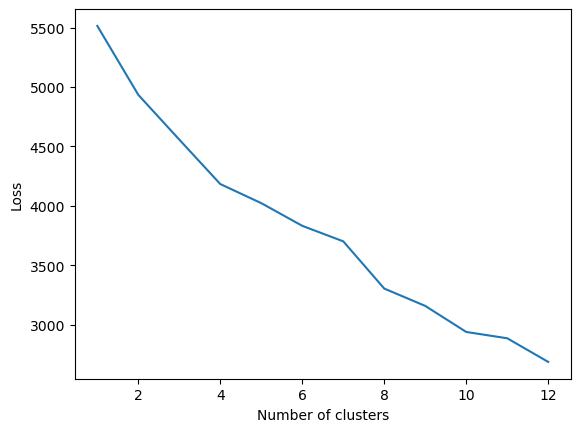

In [879]:
k_max = 12
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_4)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

As the elbow method does not present an easy result for the number of clusters we tested many and got with 4 clusters the best results.

In [880]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_scaled_4)
df_4['cluster_gmm'] = gmm.predict(X_scaled_4) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=4, random_state=42, init="k-means++")
means.fit(X_scaled_4)
df_4['cluster_km'] = means.predict(X_scaled_4)

df_4.head()

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,cluster_gmm,cluster_km
hex_start,,,,,,,,,,,,,,,,,,,,,
8826641915fffff,5.0,3.0,1.0,6.0,9.0,195.0,232.0,74.0,95.0,111.0,...,113.0,120.0,96.0,140.0,175.0,94.0,28.0,17.0,0,1
882664191dfffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
8826641937fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
8826641961fffff,38.0,19.0,21.0,75.0,57.0,181.0,245.0,193.0,250.0,306.0,...,305.0,298.0,329.0,186.0,172.0,136.0,92.0,57.0,0,1
8826641b23fffff,64.0,16.0,23.0,17.0,6.0,21.0,86.0,41.0,42.0,91.0,...,103.0,96.0,82.0,126.0,152.0,110.0,62.0,57.0,0,1


In [881]:
#rename cluster names
df_4.loc[df_4['cluster_gmm'] == 0, 'cluster_gmm'] = 'High demand'
df_4.loc[df_4['cluster_gmm'] == 3, 'cluster_gmm'] = 'Day Trips'
df_4.loc[df_4['cluster_gmm'] == 2, 'cluster_gmm'] = 'Low demand'
df_4.loc[df_4['cluster_gmm'] == 1, 'cluster_gmm'] = 'Night Trips'

df_4.loc[df_4['cluster_km'] == 1, 'cluster_km'] = 'High demand'
df_4.loc[df_4['cluster_km'] == 2, 'cluster_km'] = 'Morning Trips'
df_4.loc[df_4['cluster_km'] == 0, 'cluster_km'] = 'Low demand'
df_4.loc[df_4['cluster_km'] == 3, 'cluster_km'] = 'Afternoon Trips'

In [897]:
def plot_cluster_analysis(dataframe, cluster_column):
    # Define the number of clusters
    num_clusters = dataframe[cluster_column].nunique()

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Get unique cluster labels present in the data
    unique_clusters = dataframe[cluster_column].unique()

    # Define color mapping for specific cluster labels, using predefined colors where available
    predefined_color_mapping = {
        'High demand': 'red',
        'Low demand': 'orange',
        'Day Trips': 'blue',
        'Night Trips': 'green',
        'Morning Trips': 'blue',
        'Afternoon Trips': 'green',
        'Evening Trips': 'green',
    }

    # Generate color mapping dictionary for present clusters
    color_mapping = {
        cluster_label: predefined_color_mapping.get(cluster_label, 'gray')
        for cluster_label in unique_clusters
    }

    # Process each cluster
    for cluster_label in unique_clusters:
        cluster_df = dataframe[dataframe[cluster_column] == cluster_label].iloc[:, 0:24]
        cluster_df = cluster_df.T
        cluster_df["average"] = cluster_df.mean(axis=1)

        # Plot average hour-trips number with color mapping
        color = color_mapping.get(cluster_label, 'gray')  # Use gray for other clusters
        cluster_df["average"].plot(ax=axes[0], alpha=1, label=f"{cluster_label}", color=color)

    # Set titles and labels for the first subplot
    axes[0].set_title("Average trips per hour")
    axes[0].set_ylabel("Average trips number")
    axes[0].set_xlabel("Start Hour")
    axes[0].legend()

    # Plot cluster size with custom color palette
    sns.countplot(ax=axes[1], x=dataframe[cluster_column], palette=color_mapping.values(),  order=color_mapping.keys())
    axes[1].set_title(f"{cluster_column.capitalize()} Size")
    axes[1].set_ylabel("Number")
    axes[1].set_xlabel(cluster_column.capitalize())

    # Show the plots
    plt.tight_layout()
    plt.show()


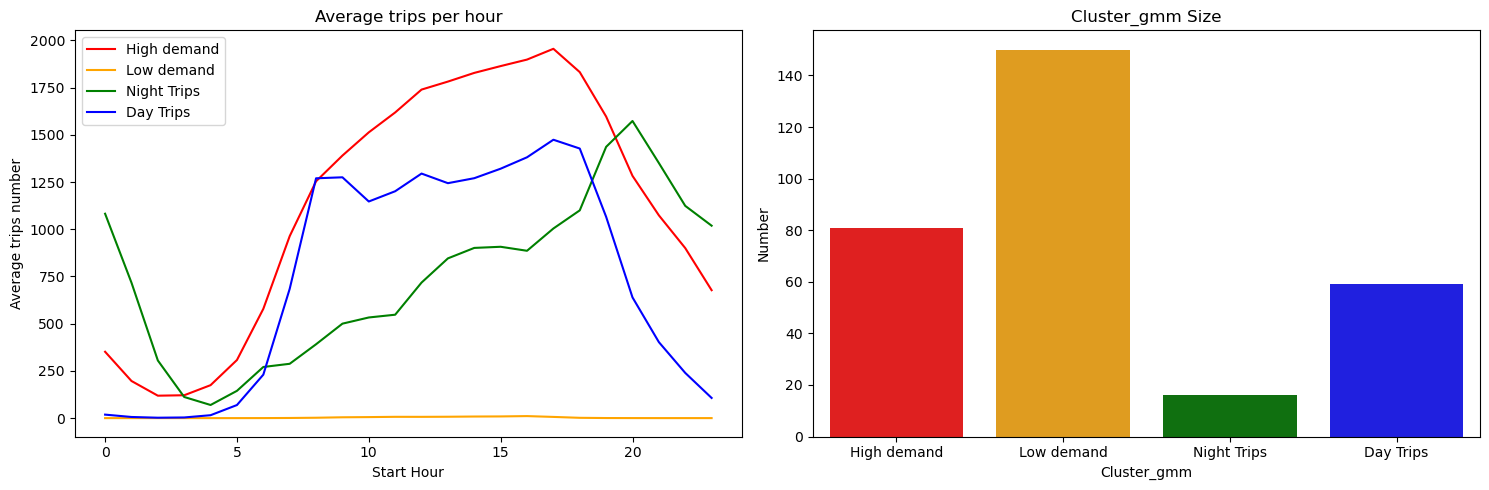

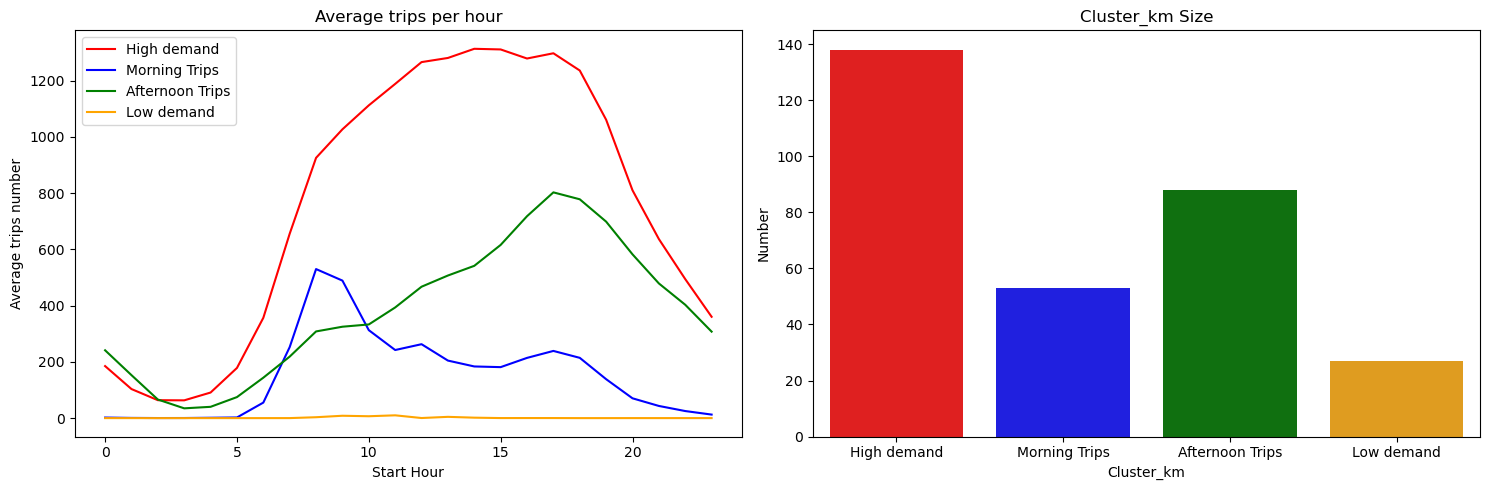

In [898]:
#plot analysis gmm
plot_cluster_analysis(df_4, 'cluster_gmm')
#plot analysis km
plot_cluster_analysis(df_4, 'cluster_km')

We can oberserve 4 different cluster for both GMM and K-Means, although they differ in their results a little.

GMM:
* **High demand**: overall high demand at all hours
* **Low demand**: overall low demand at all hours
* **Day Trips**: areas that have high demand at daytime
* **Night Trips**: areas that have their peak demand at night hours

K-Means:
* **High demand**: overall high demand at all hours
* **Low demand**: overall low demand at all hours
* **Morning Trips**: areas that have their peak demand at morning hours
* **Afternoon Trips**: areas that have their peak demand at afternoon hours

Both approaches differ in their cluster size distribution greatly as well.

In [843]:
#calculate geometry of hexagons for mapping
df_4_geo = df_4
df_4_geo['agg_hex_id'] = df_4.index
df_4_geo['geometry'] = df_4_geo['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

df_4_geo_gmm = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_gmm']], crs='EPSG:4326')
df_4_geo_km = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_km']], crs='EPSG:4326')

#plot map gmm
df_4_geo_gmm.explore(column = 'cluster_gmm', categorical = True, cmap=["Blue", "Red", "Orange", "Green"])

GMM:

High demand areas can be seen all over chicago, it is visible though that highly relevant locations like both airports, as well the city center are part of that cluster. Low demand exists more when going out of the center on the other hand. Day trips are especially present in the northern side of Chicago, close to the center. This area has more work places and people working their can in the time of this cluster both get a taxi to work, as well as back home. The cluster description above also shows a high demand here. Night Trip areas are scattered over the city and occur way less.

In [844]:
#plot map km
df_4_geo_km.explore(column = 'cluster_km', categorical = True, cmap=["Green", "Red", "Orange", "Blue"])

K-Means:

High demand areas can be seen all over chicago, it is visible here as well though that highly relevant locations like both airports, as well the city center are part of that cluster. Low demand exists way less and just when going out of the center. Morning trips are especially common at outer areas when people e.g. go to work. Afternoon trips are mainly common in th northern side close to the center when people get a taxi when going back home, since that area has more work places.

### 3.4.2 Dropoff and Workday

In [845]:
H3_HEXAGON_RESOLUTION = 8

df_4 = df[['time', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'weekend']]

#drop weekend trips
df_4 = df_4[df_4['weekend'] == 0]
df_4.drop(['weekend'], axis=1, inplace = True)

#calculate hexagon
df_4["hex_start"] = df_4.apply(lambda row: h3.geo_to_h3(row["dropoff_centroid_latitude"], row["dropoff_centroid_longitude"], H3_HEXAGON_RESOLUTION) if (row['dropoff_centroid_latitude'] and row['dropoff_centroid_longitude']) else 0, axis=1)

df_4.loc[:,"hour"] = df_4['time'].apply(lambda x: np.trunc(x))

#drop used lat and lon and time
df_4.drop(['dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'time'], axis=1, inplace=True)

#group by hour and hex and fill NaN and transpose
df_4 = df_4.groupby(['hour', 'hex_start']).size().unstack()
df_4 = df_4.fillna(0)
df_4 = df_4

df_4

hex_start,8826641915fffff,8826641961fffff,8826641b23fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645251fffff,8826645253fffff,8826645257fffff,882664529dfffff,...,88275934d3fffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,882759369dfffff,88275936b1fffff,88275936bbfffff,88275936d3fffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,11.0,28.0,31.0,501.0,64.0,11.0,0.0,0.0,0.0,0.0,...,0.0,503.0,0.0,404.0,0.0,0.0,4.0,4.0,0.0,58.0
1.0,7.0,28.0,13.0,292.0,42.0,5.0,0.0,0.0,0.0,0.0,...,0.0,183.0,0.0,250.0,0.0,0.0,4.0,1.0,0.0,33.0
2.0,1.0,34.0,6.0,293.0,31.0,3.0,0.0,0.0,0.0,0.0,...,0.0,43.0,0.0,125.0,0.0,0.0,1.0,0.0,0.0,10.0
3.0,20.0,96.0,4.0,890.0,24.0,48.0,0.0,0.0,0.0,0.0,...,0.0,119.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,13.0
4.0,6.0,44.0,1.0,1598.0,28.0,229.0,0.0,0.0,0.0,0.0,...,0.0,789.0,0.0,129.0,0.0,0.0,0.0,0.0,0.0,12.0
5.0,50.0,47.0,2.0,1810.0,28.0,720.0,0.0,0.0,0.0,0.0,...,0.0,3397.0,0.0,232.0,0.0,0.0,0.0,0.0,0.0,11.0
6.0,67.0,64.0,2.0,1811.0,49.0,1303.0,0.0,0.0,0.0,0.0,...,0.0,6979.0,2.0,245.0,0.0,0.0,0.0,0.0,0.0,21.0
7.0,97.0,90.0,29.0,1350.0,63.0,1581.0,0.0,0.0,0.0,0.0,...,0.0,8497.0,0.0,321.0,0.0,0.0,4.0,0.0,0.0,50.0
8.0,24.0,211.0,28.0,1185.0,48.0,1706.0,0.0,3.0,0.0,0.0,...,0.0,7532.0,0.0,298.0,0.0,0.0,19.0,0.0,0.0,40.0


In [846]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_4)
X_scaled_4 = scaler.transform(df_4)
df_scaled_4 = pd.DataFrame(X_scaled_4, columns=df_4.columns, index=df_4.index)

#transform for further clustering
X_scaled_4 = X_scaled_4.T
df_4 = df_4.T

df_scaled_4.head()

hex_start,8826641915fffff,8826641961fffff,8826641b23fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645251fffff,8826645253fffff,8826645257fffff,882664529dfffff,...,88275934d3fffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,882759369dfffff,88275936b1fffff,88275936bbfffff,88275936d3fffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,-1.262188,-1.215907,-0.462160,-1.386372,-0.234541,-1.144197,-0.208514,-0.700192,-0.208514,-0.208514,...,-0.208514,-1.106109,-0.544466,-0.477739,-0.420084,-0.301511,-1.035629,-0.156586,-0.57735,-0.305578
1.0,-1.400194,-1.215907,-0.889683,-1.922206,-1.060126,-1.149947,-0.208514,-0.700192,-0.208514,-0.208514,...,-0.208514,-1.174288,-0.544466,-1.048063,-0.420084,-0.301511,-1.035629,-0.646768,-0.57735,-0.851252
2.0,-1.607205,-1.175666,-1.055941,-1.919642,-1.472918,-1.151863,-0.208514,-0.700192,-0.208514,-0.208514,...,-0.208514,-1.204116,-0.544466,-1.510988,-0.420084,-0.301511,-1.165533,-0.810161,-0.57735,-1.353273
3.0,-0.951672,-0.759837,-1.103444,-0.389056,-1.735604,-1.108739,-0.208514,-0.700192,-0.208514,-0.208514,...,-0.208514,-1.187924,-0.544466,-1.622091,-0.420084,-0.301511,-1.208835,-0.810161,-0.57735,-1.287792
4.0,-1.434696,-1.108597,-1.174698,1.426111,-1.585498,-0.935282,-0.208514,-0.700192,-0.208514,-0.208514,...,-0.208514,-1.045175,-0.544466,-1.496175,-0.420084,-0.301511,-1.208835,-0.810161,-0.57735,-1.309619


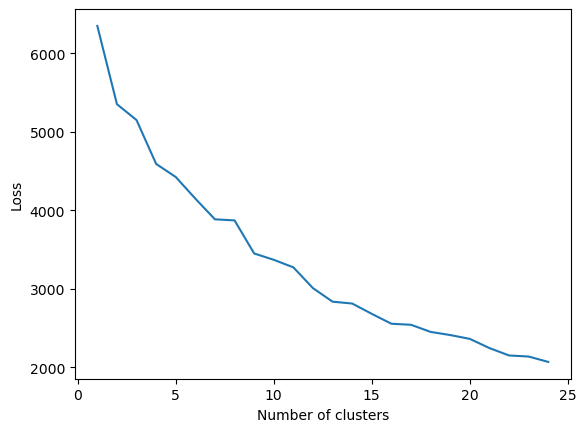

In [847]:
k_max = 24
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_4)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [848]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_scaled_4)
df_4['cluster_gmm'] = gmm.predict(X_scaled_4) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=4, random_state=42, init="k-means++")
means.fit(X_scaled_4)
df_4['cluster_km'] = means.predict(X_scaled_4)

df_4.head()

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,cluster_gmm,cluster_km
hex_start,,,,,,,,,,,,,,,,,,,,,
8826641915fffff,11.0,7.0,1.0,20.0,6.0,50.0,67.0,97.0,24.0,39.0,...,105.0,76.0,37.0,37.0,38.0,32.0,72.0,27.0,3,2
8826641961fffff,28.0,28.0,34.0,96.0,44.0,47.0,64.0,90.0,211.0,277.0,...,328.0,376.0,342.0,204.0,175.0,130.0,91.0,63.0,3,2
8826641b23fffff,31.0,13.0,6.0,4.0,1.0,2.0,2.0,29.0,28.0,36.0,...,125.0,40.0,60.0,64.0,54.0,45.0,26.0,71.0,3,2
882664520bfffff,501.0,292.0,293.0,890.0,1598.0,1810.0,1811.0,1350.0,1185.0,1166.0,...,1076.0,999.0,1028.0,1050.0,946.0,816.0,675.0,548.0,1,0
8826645215fffff,64.0,42.0,31.0,24.0,28.0,28.0,49.0,63.0,48.0,62.0,...,91.0,93.0,80.0,95.0,91.0,87.0,67.0,54.0,3,2


In [849]:
#rename cluster names
df_4.loc[df_4['cluster_gmm'] == 3, 'cluster_gmm'] = 'High demand'
df_4.loc[df_4['cluster_gmm'] == 1, 'cluster_gmm'] = 'Morning Trips'
df_4.loc[df_4['cluster_gmm'] == 0, 'cluster_gmm'] = 'Low demand'
df_4.loc[df_4['cluster_gmm'] == 2, 'cluster_gmm'] = 'Evening Trips'

df_4.loc[df_4['cluster_km'] == 2, 'cluster_km'] = 'High demand'
df_4.loc[df_4['cluster_km'] == 0, 'cluster_km'] = 'Morning Trips'
df_4.loc[df_4['cluster_km'] == 3, 'cluster_km'] = 'Low demand'
df_4.loc[df_4['cluster_km'] == 1, 'cluster_km'] = 'Evening Trips'

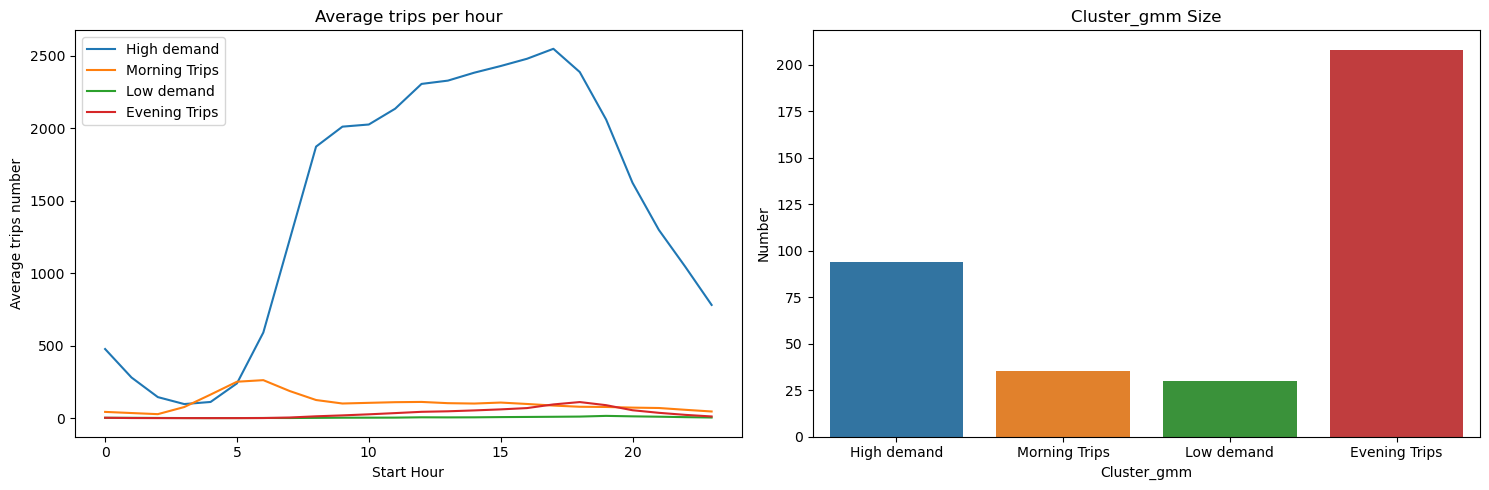

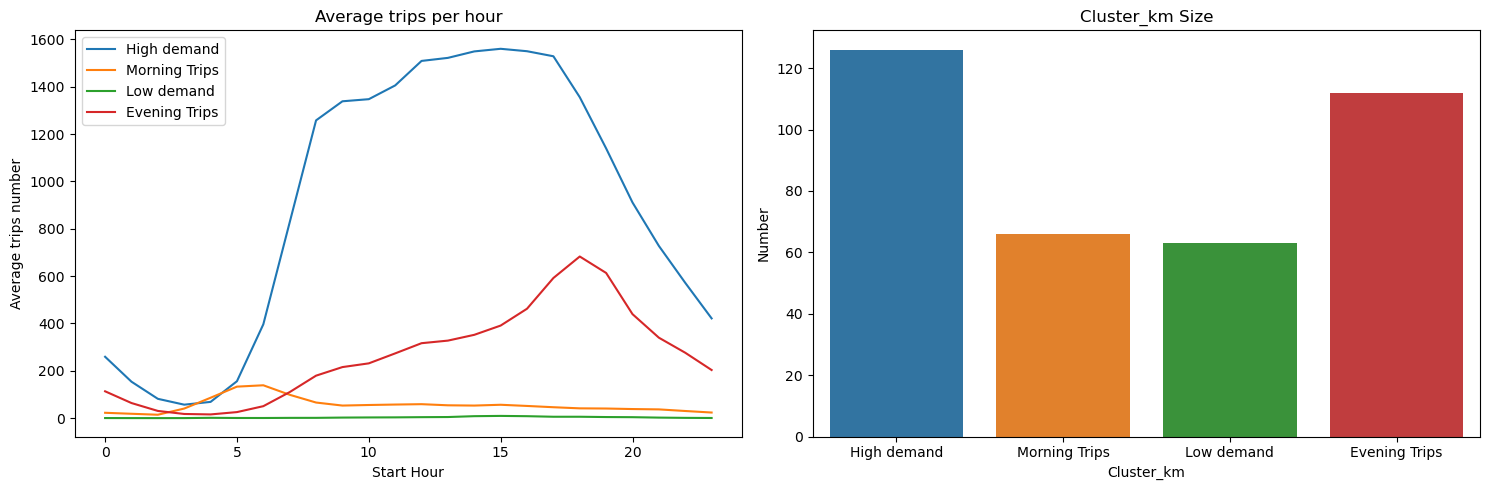

In [850]:
#plot analysis gmm
plot_cluster_analysis(df_4, 'cluster_gmm')
#plot analysis km
plot_cluster_analysis(df_4, 'cluster_km')

In [851]:
#calculate geometry of hexagons for mapping
df_4_geo = df_4
df_4_geo['agg_hex_id'] = df_4.index
df_4_geo['geometry'] = df_4_geo['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

df_4_geo_gmm = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_gmm']], crs='EPSG:4326')
df_4_geo_km = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_km']], crs='EPSG:4326')

#plot map gmm
df_4_geo_gmm.explore(column = 'cluster_gmm', categorical = True, cmap=["Green", "Red", "Orange", "Blue"])

In [852]:
#plot map km
df_4_geo_km.explore(column = 'cluster_km', categorical = True, cmap=["Green", "Red", "Orange", "Blue"])

It is visible that for the city center and close around exists a very high distribution of taxi dropoff due to people wanting to go there. 

### 3.4.3 Pickup and Weekend

In [853]:
H3_HEXAGON_RESOLUTION = 8

df_4 = df[['time', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'weekend']]

#drop workday trips
df_4 = df_4[df_4['weekend'] == 1]
df_4.drop(['weekend'], axis=1, inplace = True)

#calculate hexagon
df_4["hex_start"] = df_4.apply(lambda row: h3.geo_to_h3(row["pickup_centroid_latitude"], row["pickup_centroid_longitude"], H3_HEXAGON_RESOLUTION) if (row['pickup_centroid_latitude'] and row['pickup_centroid_longitude']) else 0, axis=1)

#round hours
df_4.loc[:,"hour"] = df_4['time'].apply(lambda x: np.trunc(x))

#drop used lat and lon and time
df_4.drop(['pickup_centroid_latitude', 'pickup_centroid_longitude', 'time'], axis=1, inplace=True)

#group by hour and hex and fill NaN and transpose
df_4 = df_4.groupby(['hour', 'hex_start']).size().unstack()
df_4 = df_4.fillna(0)
df_4 = df_4

df_4

hex_start,8826641915fffff,8826641961fffff,8826641963fffff,8826641b23fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645253fffff,8826645259fffff,88266452c9fffff,...,882664d9a1fffff,882664d9b1fffff,882664d9bdfffff,8827593433fffff,88275934cdfffff,88275934edfffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,6.0,19.0,0.0,27.0,917.0,5.0,372.0,0.0,0.0,2.0,...,0.0,0.0,108.0,3229.0,0.0,1714.0,38.0,0.0,0.0,2.0
1.0,3.0,10.0,0.0,13.0,696.0,2.0,166.0,0.0,0.0,2.0,...,0.0,0.0,39.0,2108.0,1.0,799.0,38.0,0.0,0.0,1.0
2.0,0.0,5.0,0.0,5.0,495.0,3.0,65.0,0.0,0.0,1.0,...,0.0,0.0,43.0,781.0,0.0,155.0,27.0,0.0,0.0,2.0
3.0,1.0,3.0,0.0,9.0,306.0,9.0,10.0,0.0,0.0,2.0,...,0.0,0.0,26.0,332.0,0.0,67.0,32.0,0.0,0.0,0.0
4.0,1.0,4.0,0.0,7.0,125.0,16.0,7.0,0.0,0.0,1.0,...,0.0,0.0,33.0,282.0,0.0,22.0,52.0,0.0,0.0,5.0
5.0,22.0,18.0,0.0,0.0,64.0,6.0,0.0,0.0,0.0,3.0,...,0.0,0.0,71.0,687.0,0.0,135.0,70.0,0.0,0.0,5.0
6.0,45.0,36.0,0.0,2.0,151.0,5.0,13.0,0.0,0.0,35.0,...,0.0,0.0,116.0,1487.0,0.0,311.0,135.0,0.0,0.0,6.0
7.0,28.0,46.0,0.0,3.0,364.0,7.0,92.0,0.0,0.0,1.0,...,0.0,0.0,94.0,1717.0,0.0,679.0,148.0,0.0,0.0,11.0
8.0,33.0,107.0,0.0,7.0,543.0,14.0,236.0,0.0,0.0,3.0,...,0.0,0.0,78.0,1904.0,0.0,1433.0,110.0,0.0,0.0,11.0


In [854]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_4)
X_scaled_4 = scaler.transform(df_4)
df_scaled_4 = pd.DataFrame(X_scaled_4, columns=df_4.columns, index=df_4.index)

#transform for further clustering
X_scaled_4 = X_scaled_4.T
df_4 = df_4.T

df_scaled_4.head()

hex_start,8826641915fffff,8826641961fffff,8826641963fffff,8826641b23fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645253fffff,8826645259fffff,88266452c9fffff,...,882664d9a1fffff,882664d9b1fffff,882664d9bdfffff,8827593433fffff,88275934cdfffff,88275934edfffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,-1.199719,-1.049375,-0.208514,-0.216896,0.210938,-0.825274,-0.483968,-0.301511,-0.208514,-0.875540,...,-0.208514,-0.301511,1.312950,-0.211045,-0.905357,-0.687230,-1.562748,-0.301511,-0.208514,-1.320527
1.0,-1.324907,-1.250855,-0.208514,-0.786246,-0.270480,-1.144735,-0.996990,-0.301511,-0.208514,-0.875540,...,-0.208514,-0.301511,-1.371304,-0.693823,-0.362143,-1.008307,-1.562748,-0.301511,-0.208514,-1.566206
2.0,-1.450095,-1.362788,-0.208514,-1.111590,-0.708331,-1.038248,-1.248520,-0.301511,-0.208514,-0.950054,...,-0.208514,-0.301511,-1.215695,-1.265318,-0.905357,-1.234289,-1.883811,-0.301511,-0.208514,-1.320527
3.0,-1.408366,-1.407562,-0.208514,-0.948918,-1.120041,-0.399326,-1.385492,-0.301511,-0.208514,-0.875540,...,-0.208514,-0.301511,-1.877033,-1.458687,-0.905357,-1.265169,-1.737873,-0.301511,-0.208514,-1.811886
4.0,-1.408366,-1.385175,-0.208514,-1.030254,-1.514325,0.346083,-1.392963,-0.301511,-0.208514,-0.950054,...,-0.208514,-0.301511,-1.604717,-1.480220,-0.905357,-1.280960,-1.154123,-0.301511,-0.208514,-0.583489


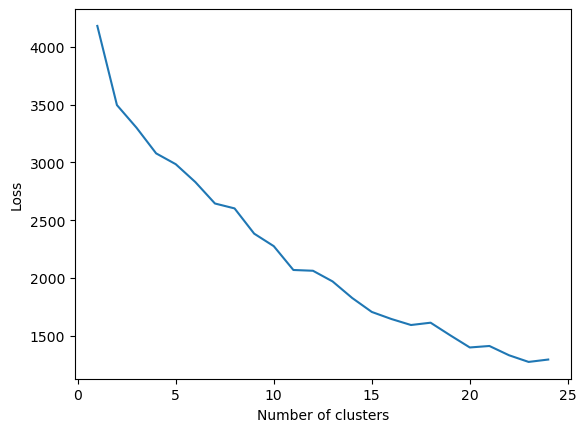

In [855]:
k_max = 24
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_4)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [856]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_scaled_4)
df_4['cluster_gmm'] = gmm.predict(X_scaled_4) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=4, random_state=42, init="k-means++")
means.fit(X_scaled_4)
df_4['cluster_km'] = means.predict(X_scaled_4)

df_4.head()

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,cluster_gmm,cluster_km
hex_start,,,,,,,,,,,,,,,,,,,,,
8826641915fffff,6.0,3.0,0.0,1.0,1.0,22.0,45.0,28.0,33.0,42.0,...,47.0,44.0,52.0,41.0,40.0,38.0,10.0,4.0,2,1
8826641961fffff,19.0,10.0,5.0,3.0,4.0,18.0,36.0,46.0,107.0,145.0,...,108.0,84.0,73.0,68.0,74.0,47.0,32.0,24.0,2,1
8826641963fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
8826641b23fffff,27.0,13.0,5.0,9.0,7.0,0.0,2.0,3.0,7.0,17.0,...,54.0,57.0,52.0,65.0,47.0,26.0,26.0,24.0,1,2
882664520bfffff,917.0,696.0,495.0,306.0,125.0,64.0,151.0,364.0,543.0,598.0,...,907.0,862.0,992.0,1108.0,1343.0,1620.0,1787.0,1699.0,0,3


In [857]:
#rename cluster names
df_4.loc[df_4['cluster_gmm'] == 1, 'cluster_gmm'] = 'High demand'
df_4.loc[df_4['cluster_gmm'] == 2, 'cluster_gmm'] = 'Day Trips'
df_4.loc[df_4['cluster_gmm'] == 3, 'cluster_gmm'] = 'Low demand'
df_4.loc[df_4['cluster_gmm'] == 0, 'cluster_gmm'] = 'Night Trips'

df_4.loc[df_4['cluster_km'] == 2, 'cluster_km'] = 'High demand'
df_4.loc[df_4['cluster_km'] == 1, 'cluster_km'] = 'Day Trips'
df_4.loc[df_4['cluster_km'] == 0, 'cluster_km'] = 'Low demand'
df_4.loc[df_4['cluster_km'] == 3, 'cluster_km'] = 'Night Trips'

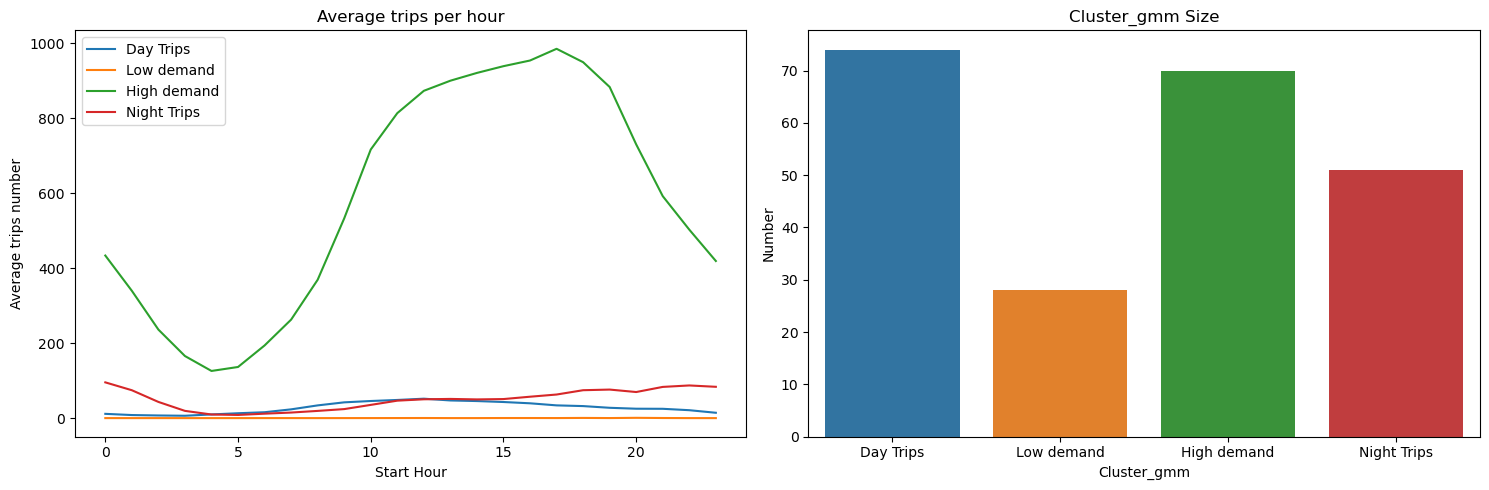

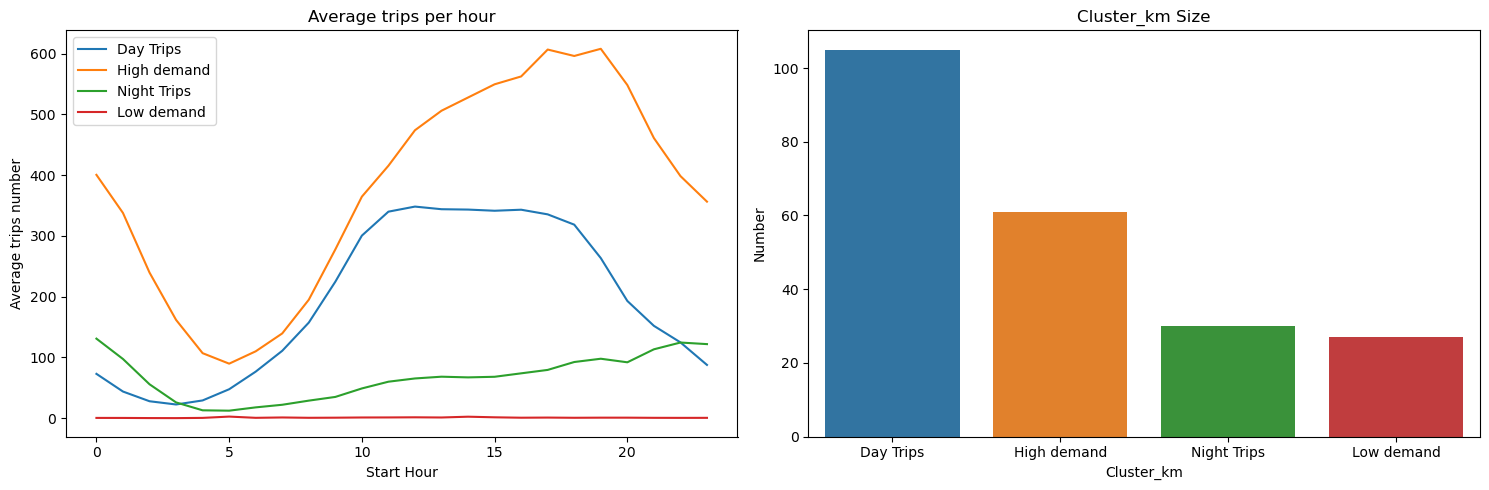

In [858]:
#plot analysis gmm
plot_cluster_analysis(df_4, 'cluster_gmm')
#plot analysis km
plot_cluster_analysis(df_4, 'cluster_km')

In [859]:
#calculate geometry of hexagons for mapping
df_4_geo = df_4
df_4_geo['agg_hex_id'] = df_4.index
df_4_geo['geometry'] = df_4_geo['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

df_4_geo_gmm = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_gmm']], crs='EPSG:4326')
df_4_geo_km = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_km']], crs='EPSG:4326')

#plot map gmm
df_4_geo_gmm.explore(column = 'cluster_gmm', categorical = True, cmap=["Blue", "Red", "Orange", "Green"])

In [860]:
#plot map km
df_4_geo_km.explore(column = 'cluster_km', categorical = True, cmap=["Blue", "Red", "Orange", "Green"])

### 3.4.4 Dropoff and Weekend

In [861]:
H3_HEXAGON_RESOLUTION = 8

df_4 = df[['time', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'weekend']]

#drop workday trips
df_4 = df_4[df_4['weekend'] == 1]
df_4.drop(['weekend'], axis=1, inplace = True)

#calculate hexagon
df_4["hex_start"] = df_4.apply(lambda row: h3.geo_to_h3(row["dropoff_centroid_latitude"], row["dropoff_centroid_longitude"], H3_HEXAGON_RESOLUTION) if (row['dropoff_centroid_latitude'] and row['dropoff_centroid_longitude']) else 0, axis=1)

df_4.loc[:,"hour"] = df_4['time'].apply(lambda x: np.trunc(x))

#drop used lat and lon and time
df_4.drop(['dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'time'], axis=1, inplace=True)

#group by hour and hex and fill NaN and transpose
df_4 = df_4.groupby(['hour', 'hex_start']).size().unstack()
df_4 = df_4.fillna(0)
df_4 = df_4

df_4

hex_start,8826641915fffff,8826641961fffff,8826641b23fffff,8826641b29fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645253fffff,8826645259fffff,88266452c9fffff,...,882759340bfffff,8827593433fffff,88275934cdfffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936bbfffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,9.0,20.0,22.0,0.0,150.0,23.0,1.0,0.0,0.0,18.0,...,8.0,385.0,280.0,170.0,0.0,182.0,0.0,2.0,3.0,36.0
1.0,2.0,10.0,4.0,0.0,86.0,13.0,2.0,0.0,0.0,17.0,...,0.0,347.0,149.0,70.0,0.0,130.0,0.0,1.0,0.0,16.0
2.0,4.0,14.0,4.0,0.0,107.0,11.0,6.0,0.0,0.0,17.0,...,0.0,242.0,23.0,41.0,0.0,67.0,0.0,0.0,0.0,12.0
3.0,1.0,6.0,5.0,0.0,351.0,21.0,51.0,0.0,0.0,7.0,...,0.0,614.0,21.0,102.0,0.0,43.0,0.0,0.0,0.0,4.0
4.0,0.0,12.0,2.0,0.0,578.0,9.0,137.0,0.0,0.0,5.0,...,0.0,1405.0,0.0,453.0,0.0,57.0,0.0,0.0,0.0,4.0
5.0,5.0,10.0,1.0,0.0,646.0,10.0,272.0,0.0,0.0,5.0,...,0.0,2550.0,4.0,1241.0,0.0,66.0,0.0,0.0,0.0,6.0
6.0,9.0,28.0,2.0,0.0,746.0,7.0,489.0,0.0,0.0,30.0,...,2.0,2646.0,9.0,2122.0,0.0,113.0,0.0,0.0,2.0,12.0
7.0,22.0,30.0,6.0,0.0,603.0,12.0,529.0,0.0,0.0,4.0,...,0.0,2086.0,19.0,2244.0,0.0,134.0,0.0,0.0,0.0,8.0
8.0,6.0,67.0,4.0,0.0,488.0,18.0,465.0,0.0,0.0,5.0,...,0.0,1396.0,23.0,2209.0,0.0,118.0,0.0,0.0,0.0,12.0


In [862]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_4)
X_scaled_4 = scaler.transform(df_4)
df_scaled_4 = pd.DataFrame(X_scaled_4, columns=df_4.columns, index=df_4.index)

#transform for further clustering
X_scaled_4 = X_scaled_4.T
df_4 = df_4.T

df_scaled_4.head()

hex_start,8826641915fffff,8826641961fffff,8826641b23fffff,8826641b29fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645253fffff,8826645259fffff,88266452c9fffff,...,882759340bfffff,8827593433fffff,88275934cdfffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936bbfffff,88275936d5fffff
hour,,,,,,,,,,,,,,,,,,,,,
0.0,-0.604045,-0.996206,0.349854,-0.208514,-1.551782,-0.161329,-1.181442,-0.484818,-0.208514,-0.308869,...,0.743974,-0.953577,0.310043,-1.123227,-0.361787,-0.071110,-0.208514,-0.461492,0.373217,0.428922
1.0,-1.180633,-1.241426,-0.849646,-0.208514,-1.940550,-1.041306,-1.178250,-0.484818,-0.208514,-0.374469,...,-0.603602,-1.014674,-0.442679,-1.195088,-0.361787,-0.658826,-0.208514,-0.605333,-0.701649,-0.714870
2.0,-1.015893,-1.143338,-0.849646,-0.208514,-1.812986,-1.217302,-1.165482,-0.484818,-0.208514,-0.374469,...,-0.603602,-1.183496,-1.166671,-1.215928,-0.361787,-1.370867,-0.208514,-0.749175,-0.701649,-0.943628
3.0,-1.263002,-1.339514,-0.783007,-0.208514,-0.330807,-0.337325,-1.021842,-0.484818,-0.208514,-1.030474,...,-0.603602,-0.585384,-1.178163,-1.172092,-0.361787,-1.642120,-0.208514,-0.749175,-0.701649,-1.401144
4.0,-1.345372,-1.192382,-0.982924,-0.208514,1.048105,-1.393297,-0.747329,-0.484818,-0.208514,-1.161675,...,-0.603602,0.686409,-1.298828,-0.919858,-0.361787,-1.483889,-0.208514,-0.749175,-0.701649,-1.401144


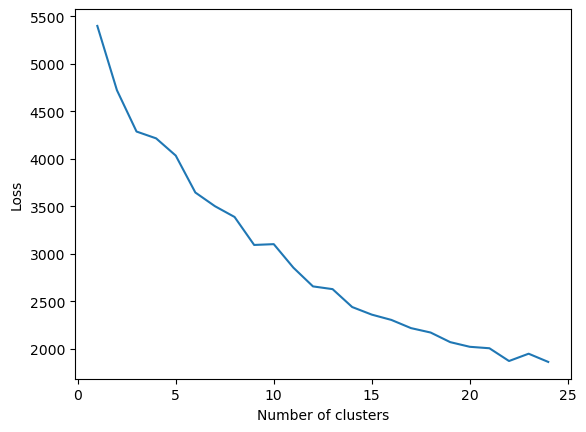

In [863]:
k_max = 24
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled_4)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [864]:
# apply GMM with specific cluster number
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_scaled_4)
df_4['cluster_gmm'] = gmm.predict(X_scaled_4) 

# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=4, random_state=42, init="k-means++")
means.fit(X_scaled_4)
df_4['cluster_km'] = means.predict(X_scaled_4)

df_4.head()

hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,cluster_gmm,cluster_km
hex_start,,,,,,,,,,,,,,,,,,,,,
8826641915fffff,9.0,2.0,4.0,1.0,0.0,5.0,9.0,22.0,6.0,14.0,...,33.0,15.0,23.0,17.0,16.0,8.0,43.0,13.0,3,2
8826641961fffff,20.0,10.0,14.0,6.0,12.0,10.0,28.0,30.0,67.0,96.0,...,93.0,93.0,101.0,62.0,67.0,35.0,34.0,18.0,3,2
8826641b23fffff,22.0,4.0,4.0,5.0,2.0,1.0,2.0,6.0,4.0,12.0,...,31.0,21.0,31.0,18.0,13.0,11.0,8.0,11.0,3,2
8826641b29fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
882664520bfffff,150.0,86.0,107.0,351.0,578.0,646.0,746.0,603.0,488.0,558.0,...,413.0,399.0,404.0,372.0,317.0,305.0,239.0,195.0,1,2


In [865]:
#rename cluster names
df_4.loc[df_4['cluster_gmm'] == 0, 'cluster_gmm'] = 'High demand'
df_4.loc[df_4['cluster_gmm'] == 1, 'cluster_gmm'] = 'Morning Trips'
df_4.loc[df_4['cluster_gmm'] == 2, 'cluster_gmm'] = 'Low demand'
df_4.loc[df_4['cluster_gmm'] == 3, 'cluster_gmm'] = 'Afternoon Trips'

df_4.loc[df_4['cluster_km'] == 2, 'cluster_km'] = 'Day Trips'
df_4.loc[df_4['cluster_km'] == 3, 'cluster_km'] = 'Morning Trips'
df_4.loc[df_4['cluster_km'] == 0, 'cluster_km'] = 'Low demand'
df_4.loc[df_4['cluster_km'] == 1, 'cluster_km'] = 'Night Trips'

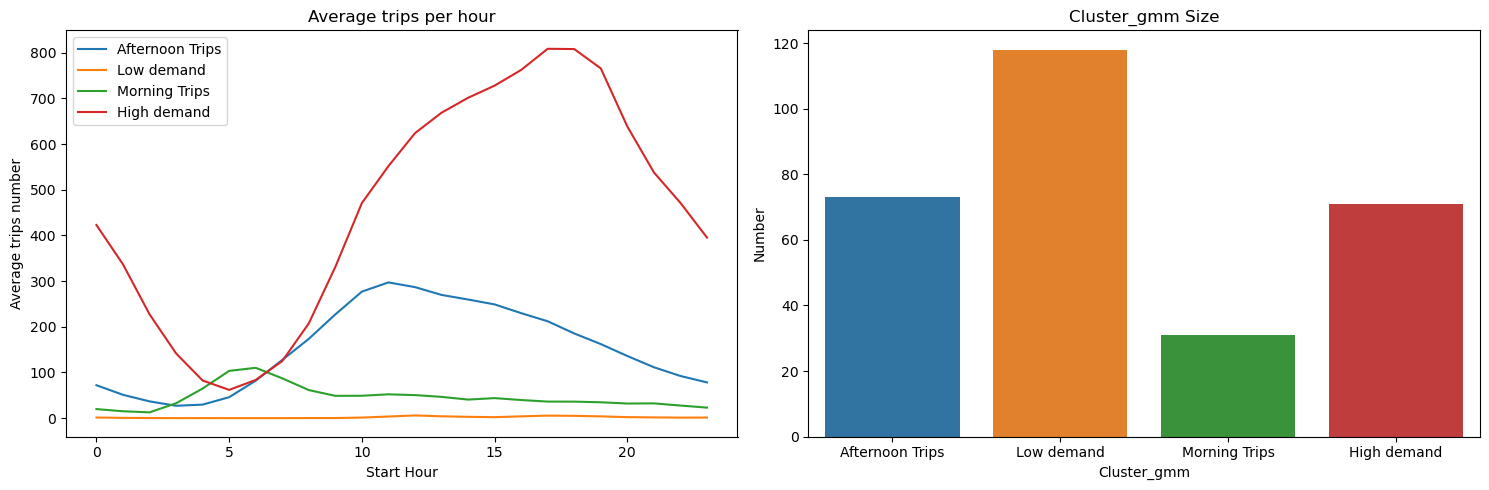

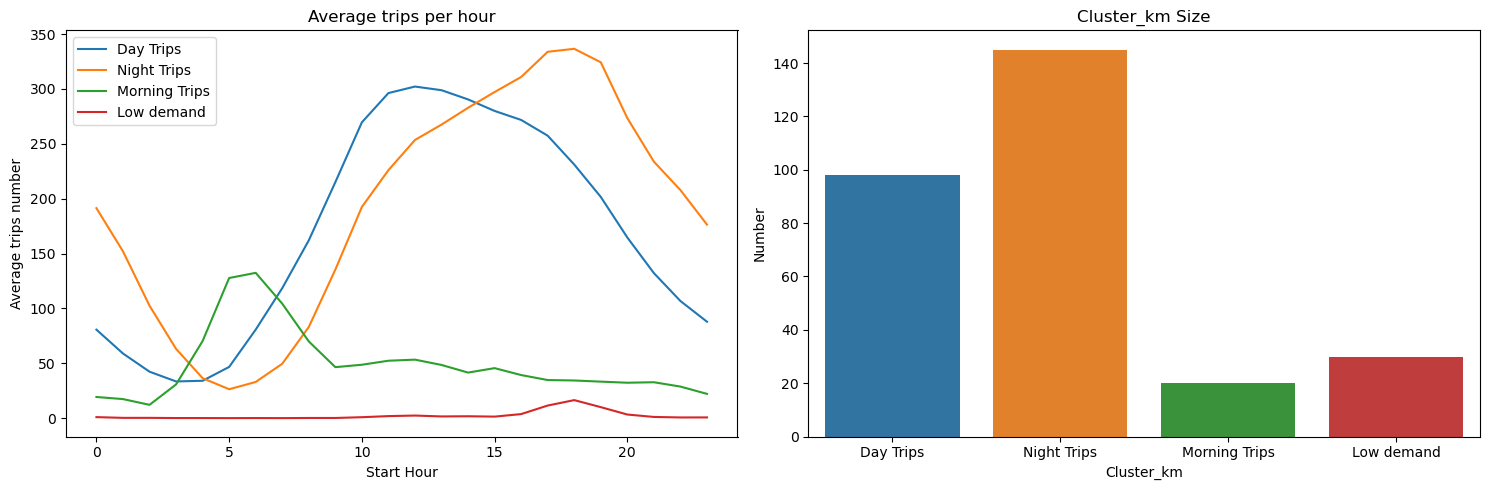

In [866]:
#plot analysis gmm
plot_cluster_analysis(df_4, 'cluster_gmm')
#plot analysis km
plot_cluster_analysis(df_4, 'cluster_km')

In [867]:
#calculate geometry of hexagons for mapping
df_4_geo = df_4
df_4_geo['agg_hex_id'] = df_4.index
df_4_geo['geometry'] = df_4_geo['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

df_4_geo_gmm = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_gmm']], crs='EPSG:4326')
df_4_geo_km = geopandas.GeoDataFrame(df_4[['geometry', 'cluster_km']], crs='EPSG:4326')

#plot map gmm
df_4_geo_gmm.explore(column = 'cluster_gmm', categorical = True, cmap=["Green", "Red", "Orange", "Blue"])

In [869]:
#plot map km
df_4_geo_km.explore(column = 'cluster_km', categorical = True, cmap=["Red", "Orange", "Blue", "Green"])